# **Defaults of Credit Card Clients** 

**Data Set Information:**
    This research aimed at the case of customersâ€™ default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel â€œSorting Smoothing Methodâ€ to estimate the real probability of default.

**Attribute Information:**
    This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* **LIMIT_BAL:** Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* **SEX:** Gender (1 = male; 2 = female).
* **EDUCATION**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* **MARRIAGE**: Marital status (1 = married; 2 = single; 3 = others).
* **AGE**: Age (year).
* **PAY_1 - PAY_6**: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: PAY_1 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; . . .;PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* **BILL_AMT1-BILL_AMT6**: Amount of bill statement (NT dollar). BILL_AMT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; . . .; BILL_AMT6 = amount of bill statement in April, 2005.
* PAY_AMT1-PAY_AMT6: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; . . .;PAY_AMT6 = amount paid in April, 2005.




## **The Business Problem**

Our client is a credit card company. They have brought us a dataset that includes
some demographics and recent financial data, over the past 6 months, for a sample
of 30,000 of their account holders. This data is at the credit account level; in other
words, there is one row for each account. Rows are labeled by whether, in the next month
after the 6-month historical data period, an account owner has defaulted, or in other
words, failed to make the minimum payment.

### **Goal**

Our goal is to develop a predictive model for whether an account will default next
month, given demographics and historical data. 
The data is already prepared, and a data dictionary is available.
Learning Repository: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.


## **Preparing the tools**

In [54]:
!pip install xlrd==2.0.1

In [55]:
!pip install shap

In [56]:
import pandas as pd 
import numpy as np 
import seaborn as sns 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score,roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import shap
import pickle

In [57]:
df = pd.read_excel('/content/default_of_credit_card_clients.xls')

In [58]:
df.shape

(30000, 25)

As can be observed in the following output, the total number of rows in the
dataset is 30,000

## **Getting Familiar with Data and Performing Data Cleaning**

In [59]:
df.columns 

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [60]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


The ID column seems like it contains unique identifiers. Now, to verify whether
they are in fact unique throughout the whole dataset

In [61]:
df['ID'].nunique()

29687

As can be seen from the preceding output, the number of unique entries is
29,687. 
>We see here that the number of unique IDs is less than the number of rows. This
implies that the ID is not a unique identifier for the rows of the data. So we know
that there is some duplication of IDs.

In [62]:
id_counts = df['ID'].value_counts()
id_counts.head()

ad23fe5c-7b09    2
1fb3e3e6-a68d    2
89f8f447-fca8    2
7c9b7473-cc2f    2
90330d02-82d9    2
Name: ID, dtype: int64

In [63]:
id_counts.value_counts()

1    29374
2      313
Name: ID, dtype: int64

Here, we can see that most IDs occur exactly once, as expected. However, 313
IDs occur twice. So, no ID occurs more than twice. With this information, we are
ready to begin taking a closer look at this data quality issue and go about fixing
it.

### Continuing Verification of Data Integrity

In [64]:
dupe_mask = id_counts == 2

In [65]:
dupe_mask[0:5]

ad23fe5c-7b09    True
1fb3e3e6-a68d    True
89f8f447-fca8    True
7c9b7473-cc2f    True
90330d02-82d9    True
Name: ID, dtype: bool

In [66]:
id_counts.index[0:5]

Index(['ad23fe5c-7b09', '1fb3e3e6-a68d', '89f8f447-fca8', '7c9b7473-cc2f',
       '90330d02-82d9'],
      dtype='object')

In [67]:
dupe_ids = id_counts.index[dupe_mask]

In [68]:
dupe_ids = list(dupe_ids)
len(dupe_ids)

313

In [69]:
dupe_ids[:5]

['ad23fe5c-7b09',
 '1fb3e3e6-a68d',
 '89f8f447-fca8',
 '7c9b7473-cc2f',
 '90330d02-82d9']

We can observe from the preceding output that the list contains the required
entries of duplicate IDs. We're now in a position to examine the data for the
IDs in our list of duplicates. In particular, we'd like to look at the values of the
features, to see what, if anything, might be different between these duplicate
entries.

In [70]:
df.loc[df['ID'].isin(dupe_ids[0:3]), :]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
5033,89f8f447-fca8,320000,2,2,1,32,0,0,0,0,0,0,160832,164750,168370,169371,172868,150827,8000,8000,5500,6100,6000,5000,0
5133,89f8f447-fca8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16727,1fb3e3e6-a68d,80000,1,2,2,33,2,2,0,0,0,0,24928,24229,25832,27394,29922,31879,0,2000,2000,3000,2600,0,1
16827,1fb3e3e6-a68d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29685,ad23fe5c-7b09,50000,1,3,1,32,0,0,0,0,0,-1,47974,43680,22133,12882,8131,3983,3000,2871,1000,163,3983,3771,1
29785,ad23fe5c-7b09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**We can see some duplicates here, and it looks like every duplicate ID has one row with data, and another row with all zeros. Is this the case for every duplicate ID?**

In [71]:
df.shape 

(30000, 25)

In [72]:
df_zero_mask = df == 0 

In [73]:
feature_zero_mask = df_zero_mask.iloc[:, 1:].all(axis = 1)

In [74]:
sum(feature_zero_mask)

315

The preceding output tells us that 315 rows have zeros for every column but the
first one. This is greater than the number of duplicate IDs (313), so if we delete all
the "zero rows," we may get rid of the duplicate ID problem.

In [75]:
df_clean_1 = df.loc[~feature_zero_mask, :].copy()

In [76]:
df_clean_1.shape

(29685, 25)

In [77]:
df_clean_1['ID'].nunique()

29685

From the preceding output, we can see that we have successfully eliminated
duplicates, as the number of unique IDs is equal to the number of rows.

## Exploring and Cleaning the Data

examining the values of the features and response
variable, the data we will use to develop our predictive model.

In [78]:
df_clean_1.info

<bound method DataFrame.info of                   ID  LIMIT_BAL  ...  PAY_AMT6  default payment next month
0      798fc410-45c1      20000  ...         0                           1
1      8a8c8f3b-8eb4     120000  ...      2000                           1
2      85698822-43f5      90000  ...      5000                           0
3      0737c11b-be42      50000  ...      1000                           0
4      3b7f77cc-dbc0      50000  ...       679                           0
...              ...        ...  ...       ...                         ...
29995  ecff42d0-bdc6     220000  ...      1000                           0
29996  99d1fa0e-222b     150000  ...         0                           0
29997  95cdd3e7-4f24      30000  ...      3100                           1
29998  00d03f02-04cd      80000  ...      1804                           1
29999  15d69f9f-5ad3      50000  ...      1000                           1

[29685 rows x 25 columns]>

We can see that there are 25 columns. Each row has 29,685
non-null values, according to this summary, which is the number of rows in
the DataFrame.

In [79]:
df_clean_1.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [80]:
df_clean_1['PAY_1'].head()

0     2
1    -1
2     0
3     0
4    -1
Name: PAY_1, dtype: object

The data from the PAY_1 column is shown
on the right. This is supposed to be the payment status of the most recent
month's bill, using the values –1, 1, 2, 3, and so on. However, we can see that
there are values of 0 here, which are not documented in the data dictionary.
According to the data dictionary, "The measurement scale for the repayment
status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two
months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months
and above" (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).
Let's take a closer look, using the value counts of this column.

In [81]:
df_clean_1['PAY_1'].value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

The preceding output reveals the presence of two undocumented values: 0 and
–2, as well as the reason this column was imported by pandas as an object
data type, instead of int64 as we would expect for integer data: there is a
'Not available' string present in this column, symbolizing missing data. For now, we'll remove rows of the dataset in which this feature has
a missing value.

**removing missing values**

In [82]:
valid_pay_1_mask = df_clean_1['PAY_1'] != 'Not available'

In [83]:
valid_pay_1_mask[0:5]

0    True
1    True
2    True
3    True
4    True
Name: PAY_1, dtype: bool

In [84]:
sum(valid_pay_1_mask)

26664

In [85]:
df_clean_2 = df_clean_1.loc[valid_pay_1_mask, :].copy()

In [86]:
df_clean_2.shape

(26664, 25)

In [87]:
df_clean_2['PAY_1'].value_counts()

 0    13087
-1     5047
 1     3261
-2     2476
 2     2378
 3      292
 4       63
 5       23
 8       17
 6       11
 7        9
Name: PAY_1, dtype: int64

In [88]:
df_clean_2['PAY_1'] = df_clean_2['PAY_1'].astype('int64')

In [89]:
df_clean_2[['PAY_1', 'PAY_2']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26664 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PAY_1   26664 non-null  int64
 1   PAY_2   26664 non-null  int64
dtypes: int64(2)
memory usage: 624.9 KB


(We are imagining that the following information)
* -2 means the account started that month with a zero balance and never used
any credit.
* -1 means the account had a balance that was paid in full.
* 0 means that at least the minimum payment was made, but the entire balance
wasn't paid (that is, a positive balance was carried to the next month).

### Exploring the Credit Limit and Demographic Features

In [90]:
import matplotlib.pyplot as plt

%matplotlib inline 
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 200

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd20d3547d0>,
      dtype=object)

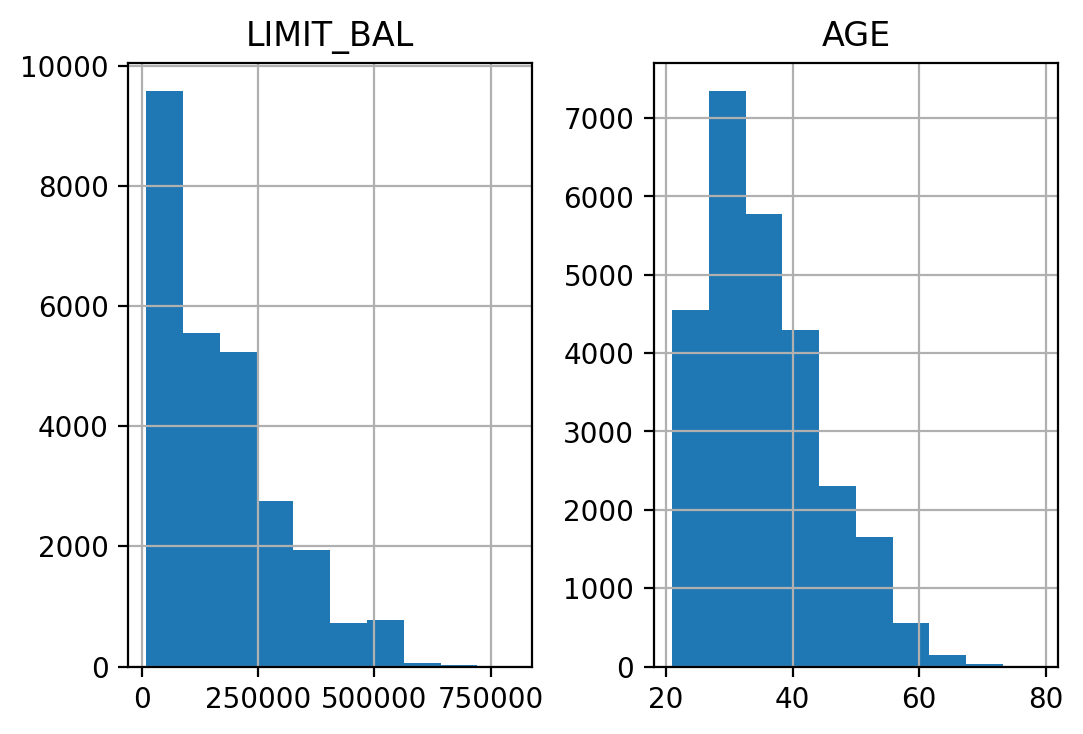

In [91]:
df_clean_2[['LIMIT_BAL', 'AGE']].hist()

In [92]:
df_clean_2[["LIMIT_BAL", "AGE"]].describe()

,LIMIT_BAL,AGE
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


**LIMIT_BAL**, the credit limit, seems to make sense. The credit limits have a
minimum of 10,000. This dataset is from Taiwan;


The **AGE** feature also looks reasonably distributed, with no one under the age of
21 having a credit account.

In [93]:
df_clean_2["EDUCATION"].value_counts()

2    12458
1     9412
3     4380
5      245
4      115
6       43
0       11
Name: EDUCATION, dtype: int64

"Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)" 
Assign unknown categories to other 

In [94]:
df_clean_2["EDUCATION"].replace(to_replace = [0, 5, 6], value = 4, inplace = True)

In [95]:
df_clean_2["EDUCATION"].value_counts()

2    12458
1     9412
3     4380
4      414
Name: EDUCATION, dtype: int64

In [96]:
df_clean_2['MARRIAGE'].value_counts()

2    14158
1    12172
3      286
0       48
Name: MARRIAGE, dtype: int64

The issue here is similar to that encountered for the EDUCATION feature; there
is a value, 0, which is not documented in the data dictionary: 1 = married; 2
= single; 3 = others. So we'll lump it in with others.

In [97]:
df_clean_2['MARRIAGE'].replace(to_replace=0, value=3, \
                               inplace=True)
df_clean_2['MARRIAGE'].value_counts()

2    14158
1    12172
3      334
Name: MARRIAGE, dtype: int64

In [98]:
df_clean_2.groupby("EDUCATION").agg({"default payment next month": "mean"})

,default payment next month
EDUCATION,
1,0.193901
2,0.235913
3,0.255479
4,0.074879


Text(0.5, 0, 'Education level: ordinal encoding')

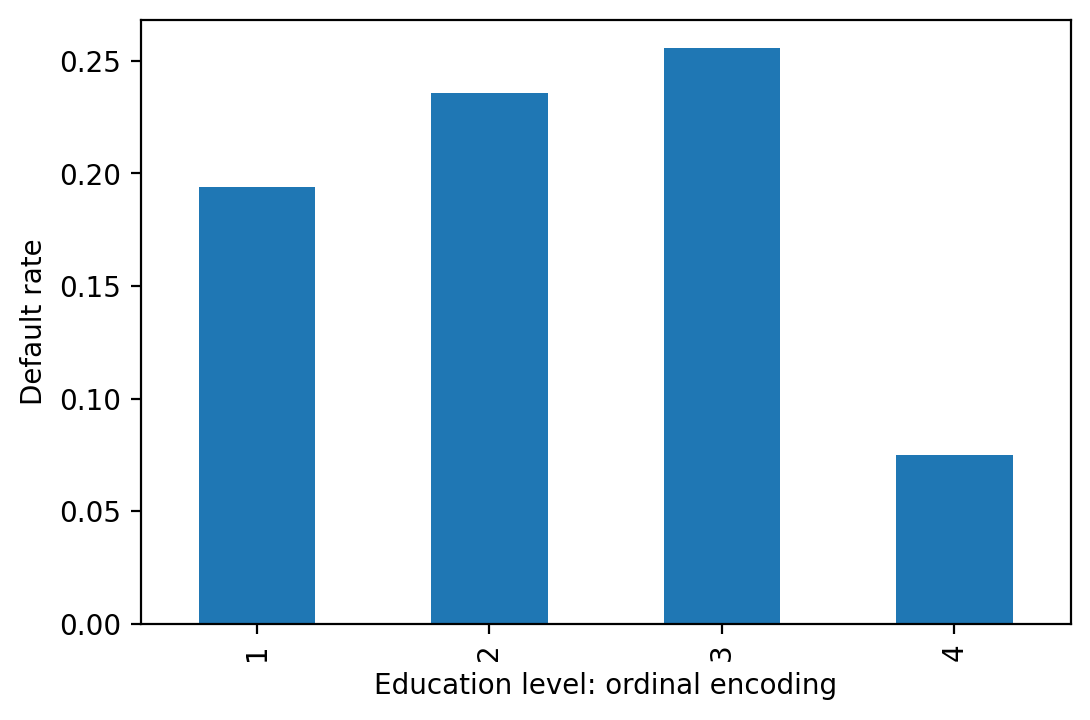

In [99]:
df_clean_2.groupby("EDUCATION").agg({"default payment next "
                                     "month": "mean"})\
                                     .plot.bar(legend = False)
plt.ylabel("Default rate")
plt.xlabel("Education level: ordinal encoding")

 it looks like a straight-line fit would probably not
be the best description of the data here. In case a feature has a non-linear effect
like this, it may be better to use a more complex algorithm such as a **decision tree**
or **random forest**. Or, if a simpler and more interpretable linear model such as
logistic regression is desired, we could avoid an ordinal encoding and use a different
way of encoding categorical variables.

### Implementing One-Hot Encoding for a Categorical Feature

In [100]:
df_clean_2["EDUCATION"].head()

0    2
1    2
2    2
3    2
4    2
Name: EDUCATION, dtype: int64

In [101]:
df_clean_2["EDUCATION_CAT"] = "none"

In [102]:
df_clean_2[["EDUCATION", "EDUCATION_CAT"]].head(10)

,EDUCATION,EDUCATION_CAT
0,2,none
1,2,none
2,2,none
3,2,none
4,2,none
5,1,none
6,1,none
7,2,none
8,3,none
9,3,none


**"Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)"**

In [103]:
cat_mapping = {1: "graduate school", 
               2: "university", 
               3: "high school",
               4: "others"}

In [104]:
df_clean_2["EDUCATION_CAT"] = df_clean_2["EDUCATION"]\
                              .map(cat_mapping)

In [105]:
df_clean_2[["EDUCATION", "EDUCATION_CAT"]].head(10)

,EDUCATION,EDUCATION_CAT
0,2,university
1,2,university
2,2,university
3,2,university
4,2,university
5,1,graduate school
6,1,graduate school
7,2,university
8,3,high school
9,3,high school


In [106]:
edu_ohe = pd.get_dummies(df_clean_2["EDUCATION_CAT"])
edu_ohe.head(10)

,graduate school,high school,others,university
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,1,0,0,0
6,1,0,0,0
7,0,0,0,1
8,0,1,0,0
9,0,1,0,0


In [107]:
df_with_ohe = pd.concat([df_clean_2, edu_ohe],axis = 1)
df_with_ohe[["EDUCATION_CAT", "graduate school", "high school", "university", "others"]].head(10)

,EDUCATION_CAT,graduate school,high school,university,others
0,university,0,0,1,0
1,university,0,0,1,0
2,university,0,0,1,0
3,university,0,0,1,0
4,university,0,0,1,0
5,graduate school,1,0,0,0
6,graduate school,1,0,0,0
7,university,0,0,1,0
8,high school,0,1,0,0
9,high school,0,1,0,0


In [108]:
df_with_ohe.to_csv("Cleaned_data.csv", index = False)

### Exploring the Financial History Features in the Dataset

In [109]:
df = pd.read_csv("Cleaned_data.csv")

The remaining features to be examined are the financial history features. They fall
naturally into three groups: the status of the monthly payments for the last 6 months,
and the billed and paid amounts for the same period. First, let's look at the payment
statuses. 

In [110]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,university,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,university,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,university,0,0,0,1


In [111]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

In [112]:
df.shape

(26664, 30)

In [113]:
pay_feats = ["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

In [114]:
df[pay_feats].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,-0.017777,-0.133363,-0.167679,-0.225023,-0.269764,-0.293579
std,1.126769,1.198640,1.199165,1.167897,1.131735,1.150229
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


Here, we observe that the range of values is the same for all of these features: -2, -1,
0, ... 8. It appears that the value of 9, described in the data dictionary as payment delay
for nine months and above, is never observed.

In [115]:
df[pay_feats[0]].value_counts().sort_index()

-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: PAY_1, dtype: int64

Compared to the positive integer values, most of the values are either -2, -1, or 0,
which correspond to an account that was in good standing last month: not used, paid
in full, or made at least the minimum payment.

In [116]:
pay_feats[0]

'PAY_1'

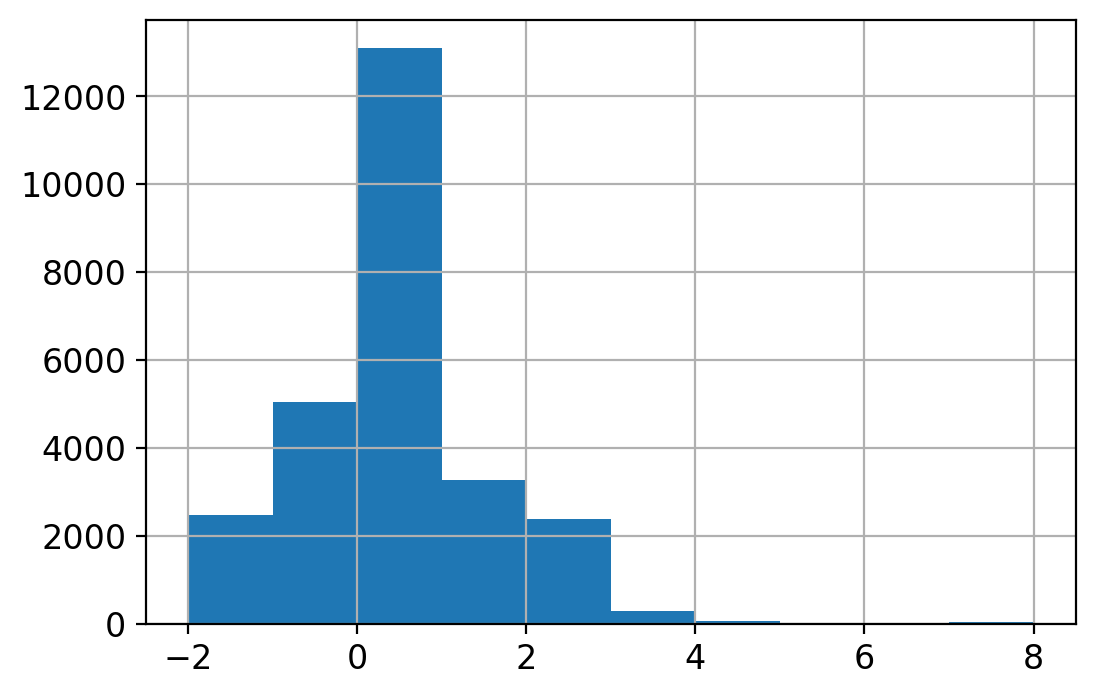

In [117]:
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["font.size"] = 12
df[pay_feats[0]].hist()

In [118]:
pay_1_bins = np.array(range(-2, 10)) - 0.5
pay_1_bins

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,
        8.5])

Text(0, 0.5, 'Number of accounts')

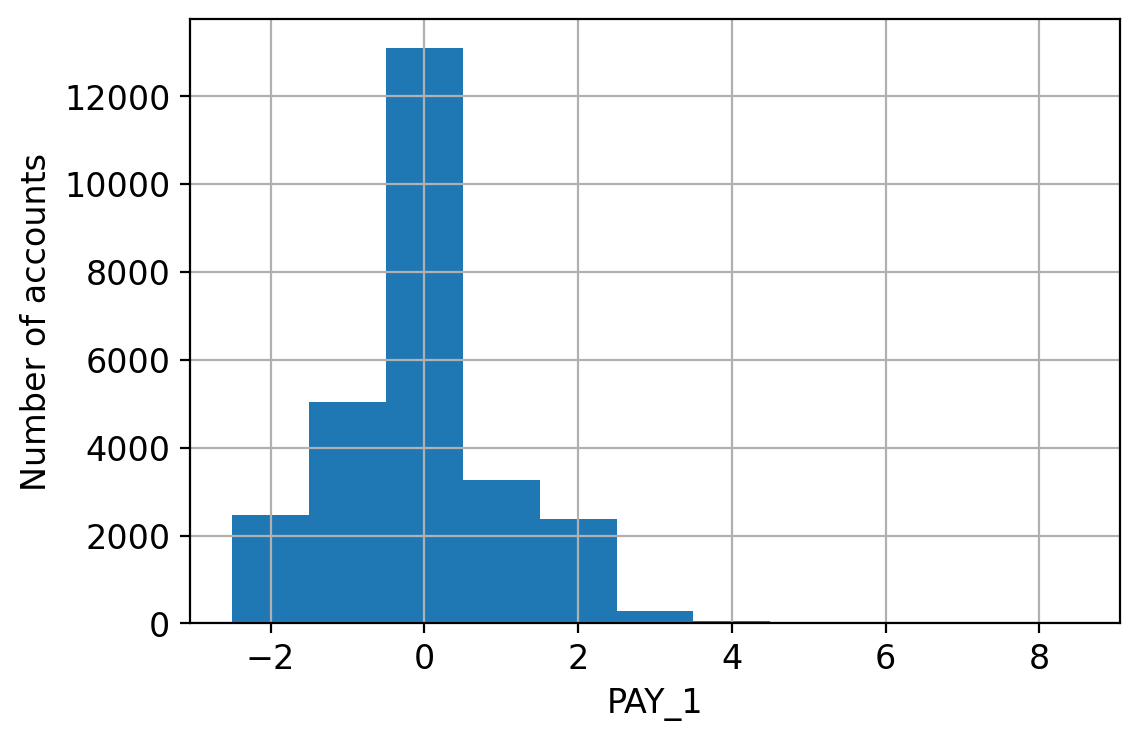

In [119]:
df[pay_feats[0]].hist(bins = pay_1_bins)
plt.xlabel("PAY_1")
plt.ylabel("Number of accounts")

Since we already looked at the value counts, this confirms for us that most accounts
are in good standing (values -2, -1, and 0). For those that aren't, it's more common for
the "months late" to be a smaller number. This makes sense; likely, most people are
paying off their balances before too long. Otherwise, their account may be closed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd210c48e10>,
      dtype=object)

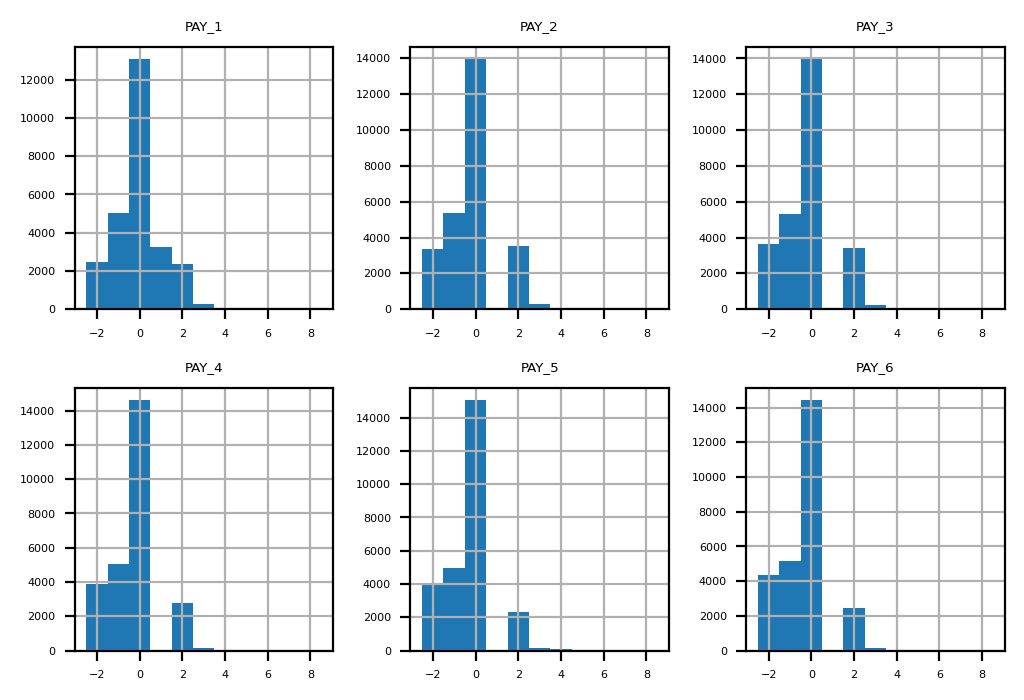

In [120]:
mpl.rcParams["font.size"] = 4 
df[pay_feats].hist(bins = pay_1_bins, layout = (2, 3))

Considering the values between July
(PAY_3) and August (PAY_2). In July, there are very few accounts that had a 1-month
payment delay; this bar is not really visible in the histogram. However, in August,
there are suddenly thousands of accounts with a 2-month payment delay. This does
not make sense: the number of accounts with a 2-month delay in a given month
should be less than or equal to the number of accounts with a 1-month delay in the
previous month.

In [121]:
df.loc[df["PAY_2"] == 2, ["PAY_2", "PAY_3"]].head()

,PAY_2,PAY_3
0,2,-1
1,2,0
13,2,2
15,2,0
47,2,2


it's clear that accounts with a 2-month delay in August have
nonsensical values for the July payment status. The only way to progress to a 2-month
delay should be from a 1-month delay the previous month, yet none of these
accounts indicate that.

only the most recent month of our payment status data is correct.
This means that, of all the payment status features, only PAY_1 is representative of
future data, those that will be used to make predictions with the model we develop. 

In [122]:
bill_feats = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
              'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_feats = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [123]:
df[bill_feats].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,51405.730723,49300.001500,47026.340047,43338.894539,40338.136701,38889.872337
std,73633.687106,70934.549534,68705.359524,64275.250740,60705.944083,59432.541657
min,-165580.000000,-69777.000000,-157264.000000,-170000.000000,-81334.000000,-339603.000000
25%,3580.000000,2999.750000,2627.250000,2341.750000,1745.000000,1256.000000
50%,22361.000000,21150.000000,20079.500000,19037.000000,18066.000000,17005.000000
75%,67649.750000,64395.500000,60360.000000,54727.500000,50290.500000,49253.750000
max,746814.000000,671563.000000,855086.000000,706864.000000,823540.000000,699944.000000


We see that the average monthly bill is roughly 40,000 to 50,000 NT dollars. We also notice there are some negative bill amounts. This seems reasonable
because of the possible overpayment of the previous month's bill, perhaps in
anticipation of a purchase that would show up on the current month's bill. A
scenario like this would leave that account with a negative balance, in the sense
of a credit to the account holder.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd210ac0210>,
      dtype=object)

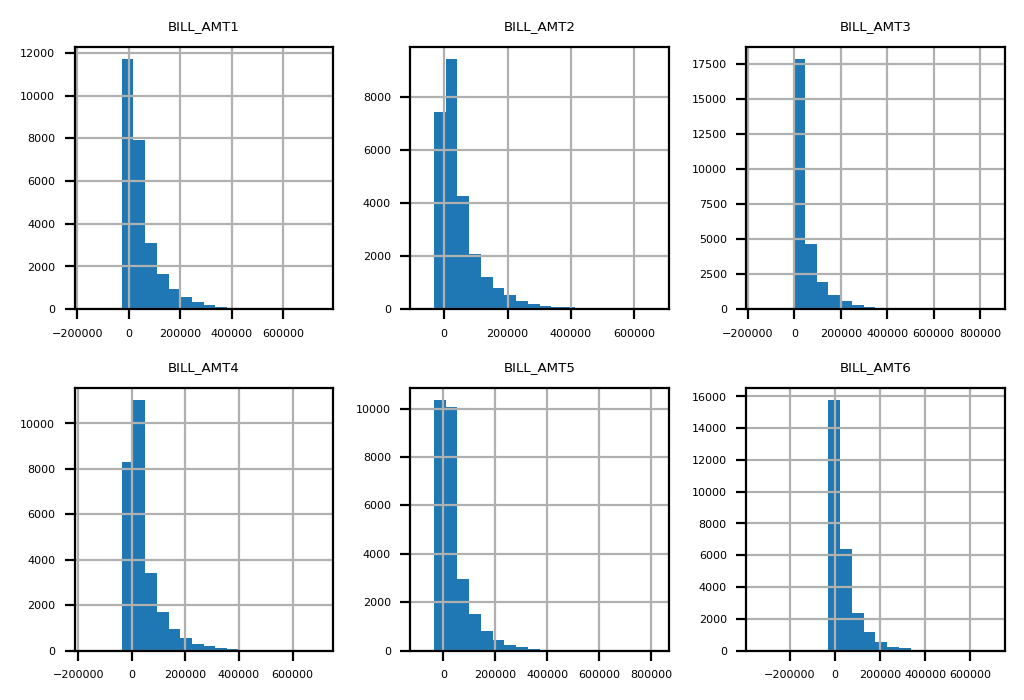

In [124]:
df[bill_feats].hist(bins=20, layout=(2,3))

Most accounts
have relatively small bills. There is a steady decrease in the number of accounts
as the amount of the bill increases. It also appears that the distribution of
billed amounts is roughly similar month to month, so we don't notice any data
inconsistency issues as we did with the payment status features. This feature
appears to p

In [125]:
df[pay_amt_feats].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,26664.000000,2.666400e+04,26664.000000,26664.000000,26664.000000,26664.000000
mean,5704.085771,5.881110e+03,5259.514964,4887.048717,4843.729973,5257.843047
std,16699.398632,2.121431e+04,17265.439561,15956.349371,15311.721795,17635.468185
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.020000e+02,390.000000,294.750000,242.750000,111.000000
50%,2114.500000,2.007000e+03,1822.000000,1500.000000,1500.000000,1500.000000
75%,5027.000000,5.000000e+03,4556.250000,4050.500000,4082.750000,4015.000000
max,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,528666.000000


There are
no negative payments, which also seems right.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2103af510>,
      dtype=object)

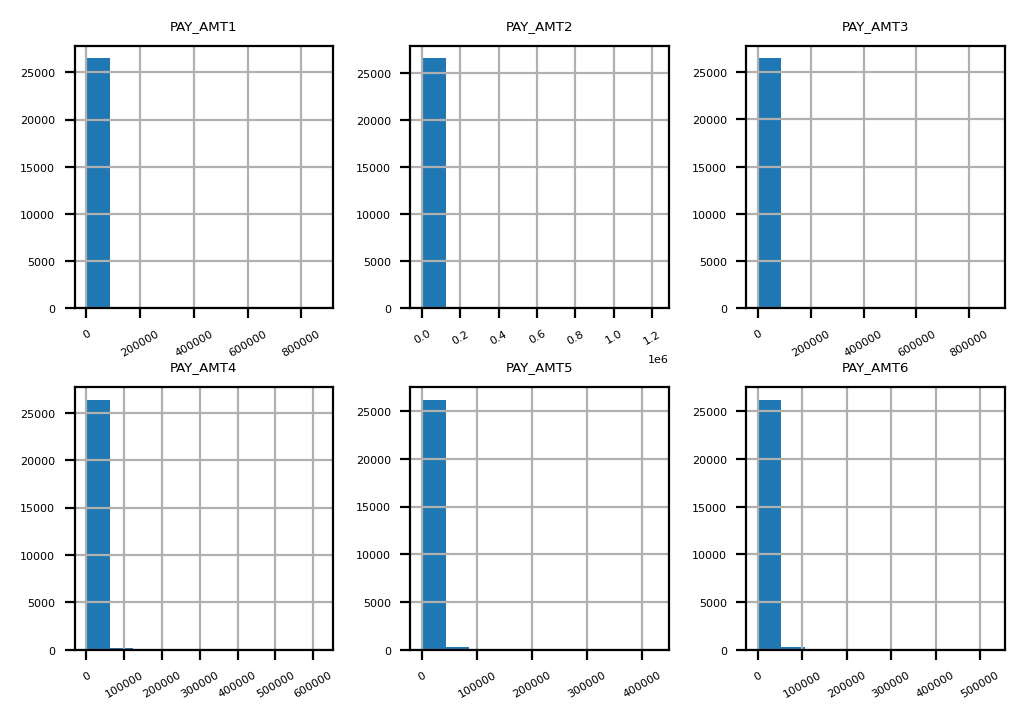

In [126]:
df[pay_amt_feats].hist(layout=(2,3), xrot=30)

A quick glance at this figure indicates that this is not a very informative graphic;
there is only one bin in most of the histograms that is of a noticeable height. This
is not an effective way to visualize this data. It appears that the monthly payment
amounts are mainly in a bin that includes 0. How many are in fact 0?

In [127]:
pay_zero_mask = df[pay_amt_feats] == 0

In [128]:
pay_zero_mask.head()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,True,False,True,True,True,True
1,True,False,False,False,True,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False


In [129]:
pay_zero_mask.sum()

PAY_AMT1    4656
PAY_AMT2    4833
PAY_AMT3    5293
PAY_AMT4    5697
PAY_AMT5    5981
PAY_AMT6    6373
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd21109f590>,
      dtype=object)

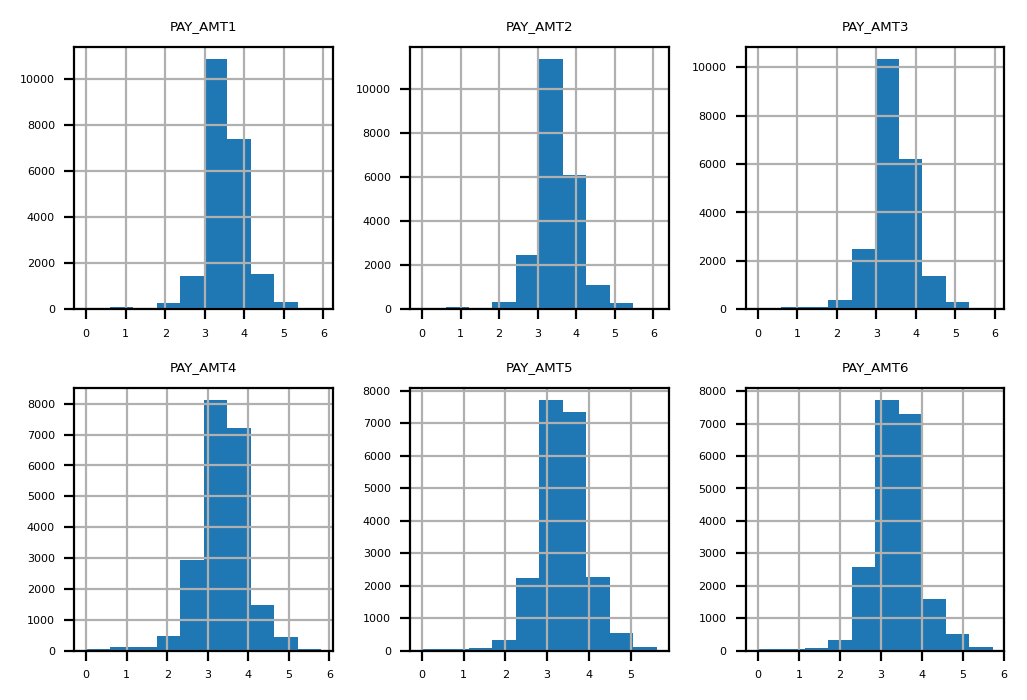

In [130]:
df[pay_amt_feats][~pay_zero_mask].apply(np.log10)\
                                 .hist(layout=(2,3))

The result is a more effective data visualization: the values are spread in a more
informative way across the histogram bins. We can see that the most commonly
occurring bill payments are in the range of thousands (log10(1,000) = 3), which
matches what we observed for the mean bill payment in the statistical summary.
There are some pretty small bill payments, and also a few pretty large ones. Overall,
the distribution of bill payments appears pretty consistent from month to month, so
we don't see any potential issues with this data.

## **Exploring the Response Variable and Concluding the Initial Exploration**

We have now looked through all the features to see whether any data is missing,
as well as to generally examine them. The features are important because they
constitute the inputs to our machine learning algorithm. On the other side of the
model lies the output, which is a prediction of the response variable. For our
problem, this is a binary flag indicating whether or not a credit account will default
next month.
The key task for the case study project is to come up with a predictive model for this
target. Since the response variable is a yes/no flag, this problem is called a binary
classification task. In our labeled data, the samples (accounts) that defaulted (that is,
'default payment next month' = 1) are said to belong to the positive class,
while those that didn't belong to the negative class. 

In [131]:
df['default payment next month'].mean()

0.2217971797179718

In [132]:
df.groupby('default payment next month')['ID'].count()

default payment next month
0    20750
1     5914
Name: ID, dtype: int64

Since the target variable is 1 or 0, taking the mean of this column indicates the
fraction of accounts that defaulted: 22%. The proportion of samples in the positive
class (default = 1), also called the class fraction for this class, is an important
statistic.

## **Examining the Relationships Between Features and the Response Variable**

In order to make accurate predictions of the response variable, good features are
necessary. We need features that are clearly linked to the response variable in
some way. Thus far, we've examined the relationship between a couple of features
and the response variable, either by calculating the groupby/mean of a feature
and the response variable, or using individual features in a model and examining
performance. However, we have not yet done a systematic exploration of how all the
features relate to the response variable. W

In [133]:
features_response = df.columns.tolist()

In [134]:
features_response[:5]

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']

In [135]:
features_response[-5:]

['EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']

Recall that we are not to use the gender variable due to ethical concerns, and we
learned that PAY_2, PAY_3,…, PAY_6 are incorrect and should be ignored. Also, we
are not going to examine the one-hot encoding we created from the EDUCATION
variable, since the information from those columns is already included in the original
feature, at least in some form. We will just use the EDUCATION feature directly.
Finally, it makes no sense to use ID as a feature, since this is simply a unique account
identifier and has nothing to do with the response variable.

In [136]:
items_to_remove = ['ID', 'SEX',
                   'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT',
                   'graduate school', 'high school', 'none',
                   'others', 'university']

In [137]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [138]:
corr = df[features_response].corr()
corr.iloc[0:5,0:5]

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1
LIMIT_BAL,1.000000,-0.232688,-0.111873,0.149157,-0.273396
EDUCATION,-0.232688,1.000000,-0.137097,0.179035,0.112653
MARRIAGE,-0.111873,-0.137097,1.000000,-0.412828,0.019759
AGE,0.149157,0.179035,-0.412828,1.000000,-0.044277
PAY_1,-0.273396,0.112653,0.019759,-0.044277,1.000000


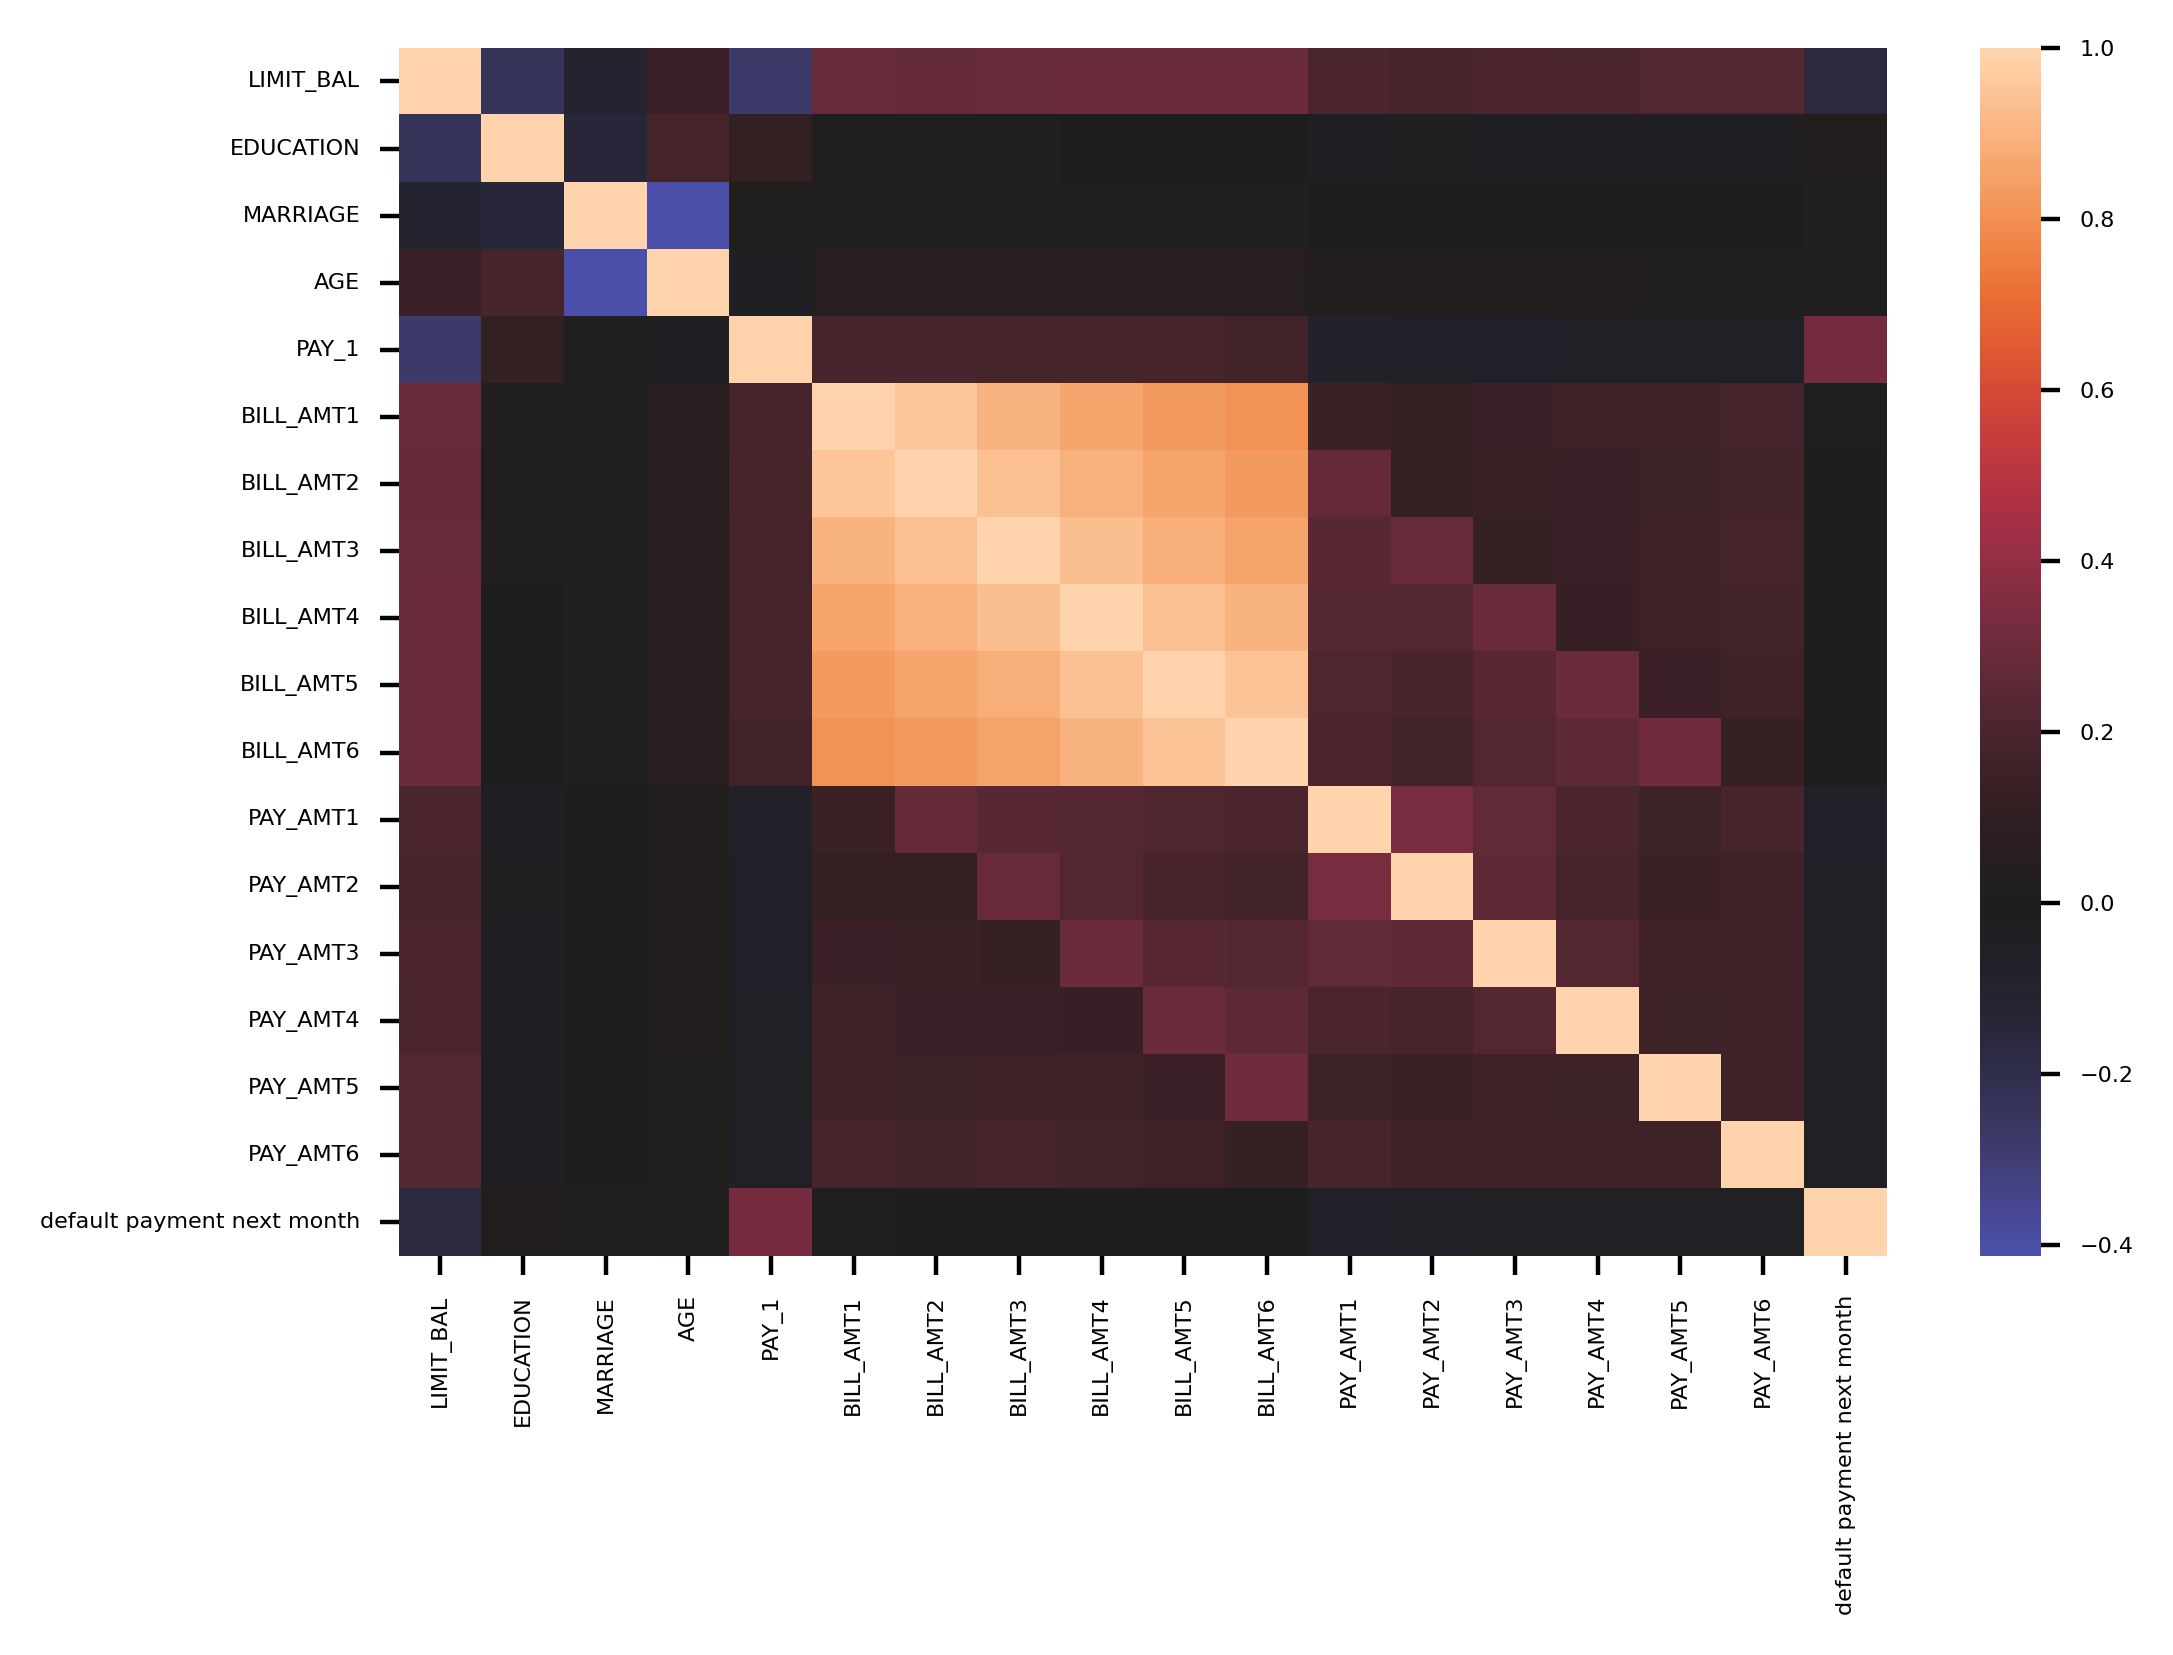

In [139]:
mpl.rcParams['figure.dpi'] = 400 #high res figures
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0)

Here we see that the PAY_1 feature is probably the
most strongly correlated feature to the response variable. We can also see that a
number of features are highly correlated to each other, in particular the BILL_AMT
features.

For now, we make the observation that PAY_1 is likely going to be one of
the best, most predictive features for our model. The other feature that looks like it
may be important is LIMIT_BAL, which is negatively correlated. Depending on how
astute your vision is, only these two really appear to be any color other than black
(meaning 0 correlation) in the bottom row

we'll use the F-test to examine the relationship between the features
and response variable. We will use this method to do what is called univariate
feature selection: the practice of testing features one by one against the response
variable, to see which ones have predictive power

In [140]:
X = df[features_response].iloc[:,:-1].values
y = df[features_response].iloc[:,-1].values
print(X.shape, y.shape)

(26664, 17) (26664,)


There are 17 features, and both the features and response arrays have the same
number of samples as expected.

In [141]:
from sklearn.feature_selection import f_classif

In [142]:
[f_stat, f_p_value] = f_classif(X, y)

In [143]:
f_test_df = pd.DataFrame({'Feature':features_response[:-1],
                          'F statistic':f_stat,
                          'p value':f_p_value})
f_test_df.sort_values('p value')

,Feature,F statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


The conclusions we can draw from the DataFrame of F-statistics and p-values
are similar to what we observed in the correlation plot: PAY_1 and LIMIT_
BAL appear to be the most useful features. They have the smallest p-values,
indicating the average values of these features are significantly different
between the positive and negative classes, and these features will help predict
which class a sample belongs to.

In [144]:
from sklearn.feature_selection import SelectPercentile

In [145]:
selector = SelectPercentile(f_classif, percentile=20)

In [146]:
selector.fit(X, y)

SelectPercentile(percentile=20)

In [147]:
best_feature_ix = selector.get_support()
best_feature_ix

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [148]:
features = features_response[:-1]

In [149]:
best_features = [features[counter]
                 for counter in range(len(features))
                 if best_feature_ix[counter]]

In [150]:
best_features

['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2']

The selected features agree with the top four rows of our DataFrame of F-test
results, so the feature selection has worked as expected.

## **Visualizing the Relationship Between the Features and Response Variable**

In [151]:
overall_default_rate = df['default payment next month'].mean()
overall_default_rate

0.2217971797179718

In [152]:
group_by_pay_mean_y = df.groupby('PAY_1').agg(
    {'default payment next month':np.mean})
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


Looking at these values, we already be able to discern the trend.

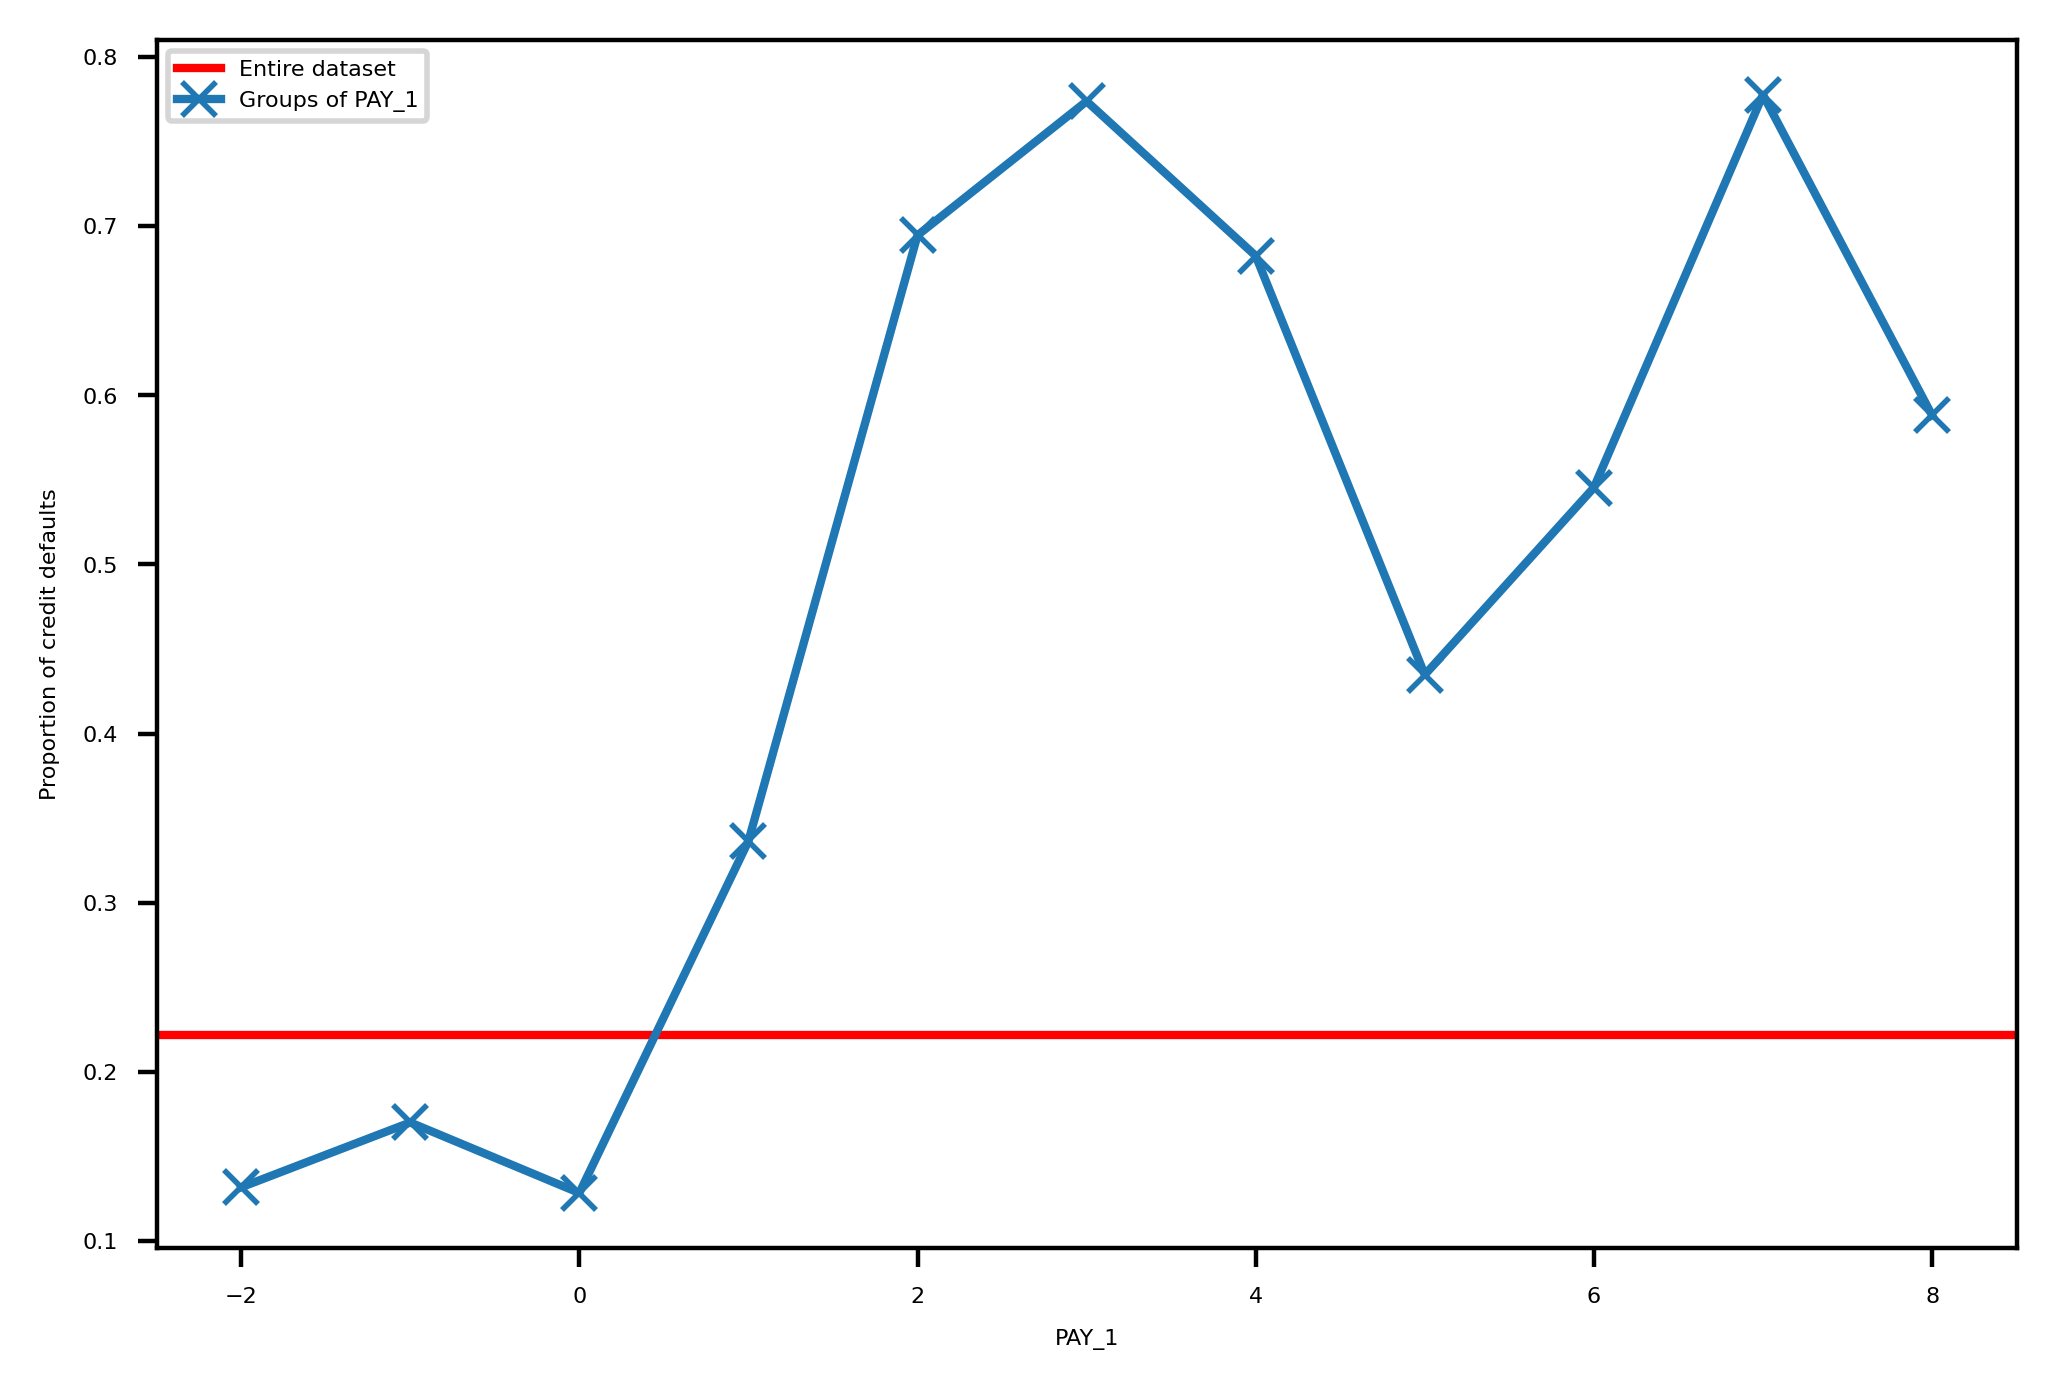

In [153]:
axes = plt.axes()
axes.axhline(overall_default_rate, color='red')
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proportion of credit defaults')
axes.legend(['Entire dataset', 'Groups of PAY_1'])

Our visualization of payment statuses has revealed a clear, and probably
expected, story: those who defaulted before are in fact more likely to default
again. The default rate of accounts in good standing is well below the overall
default rate, which we know from before is about 22%. However, over 30%
of the accounts that were in default last month will be in default again next
month, according to this

Attention to the feature ranked as having the second strongest
association with the target variable: LIMIT_BAL. This is a numerical feature
with many unique values

In [154]:
pos_mask = y == 1
neg_mask = y == 0

Text(0.5, 1.0, 'Credit limits by response variable')

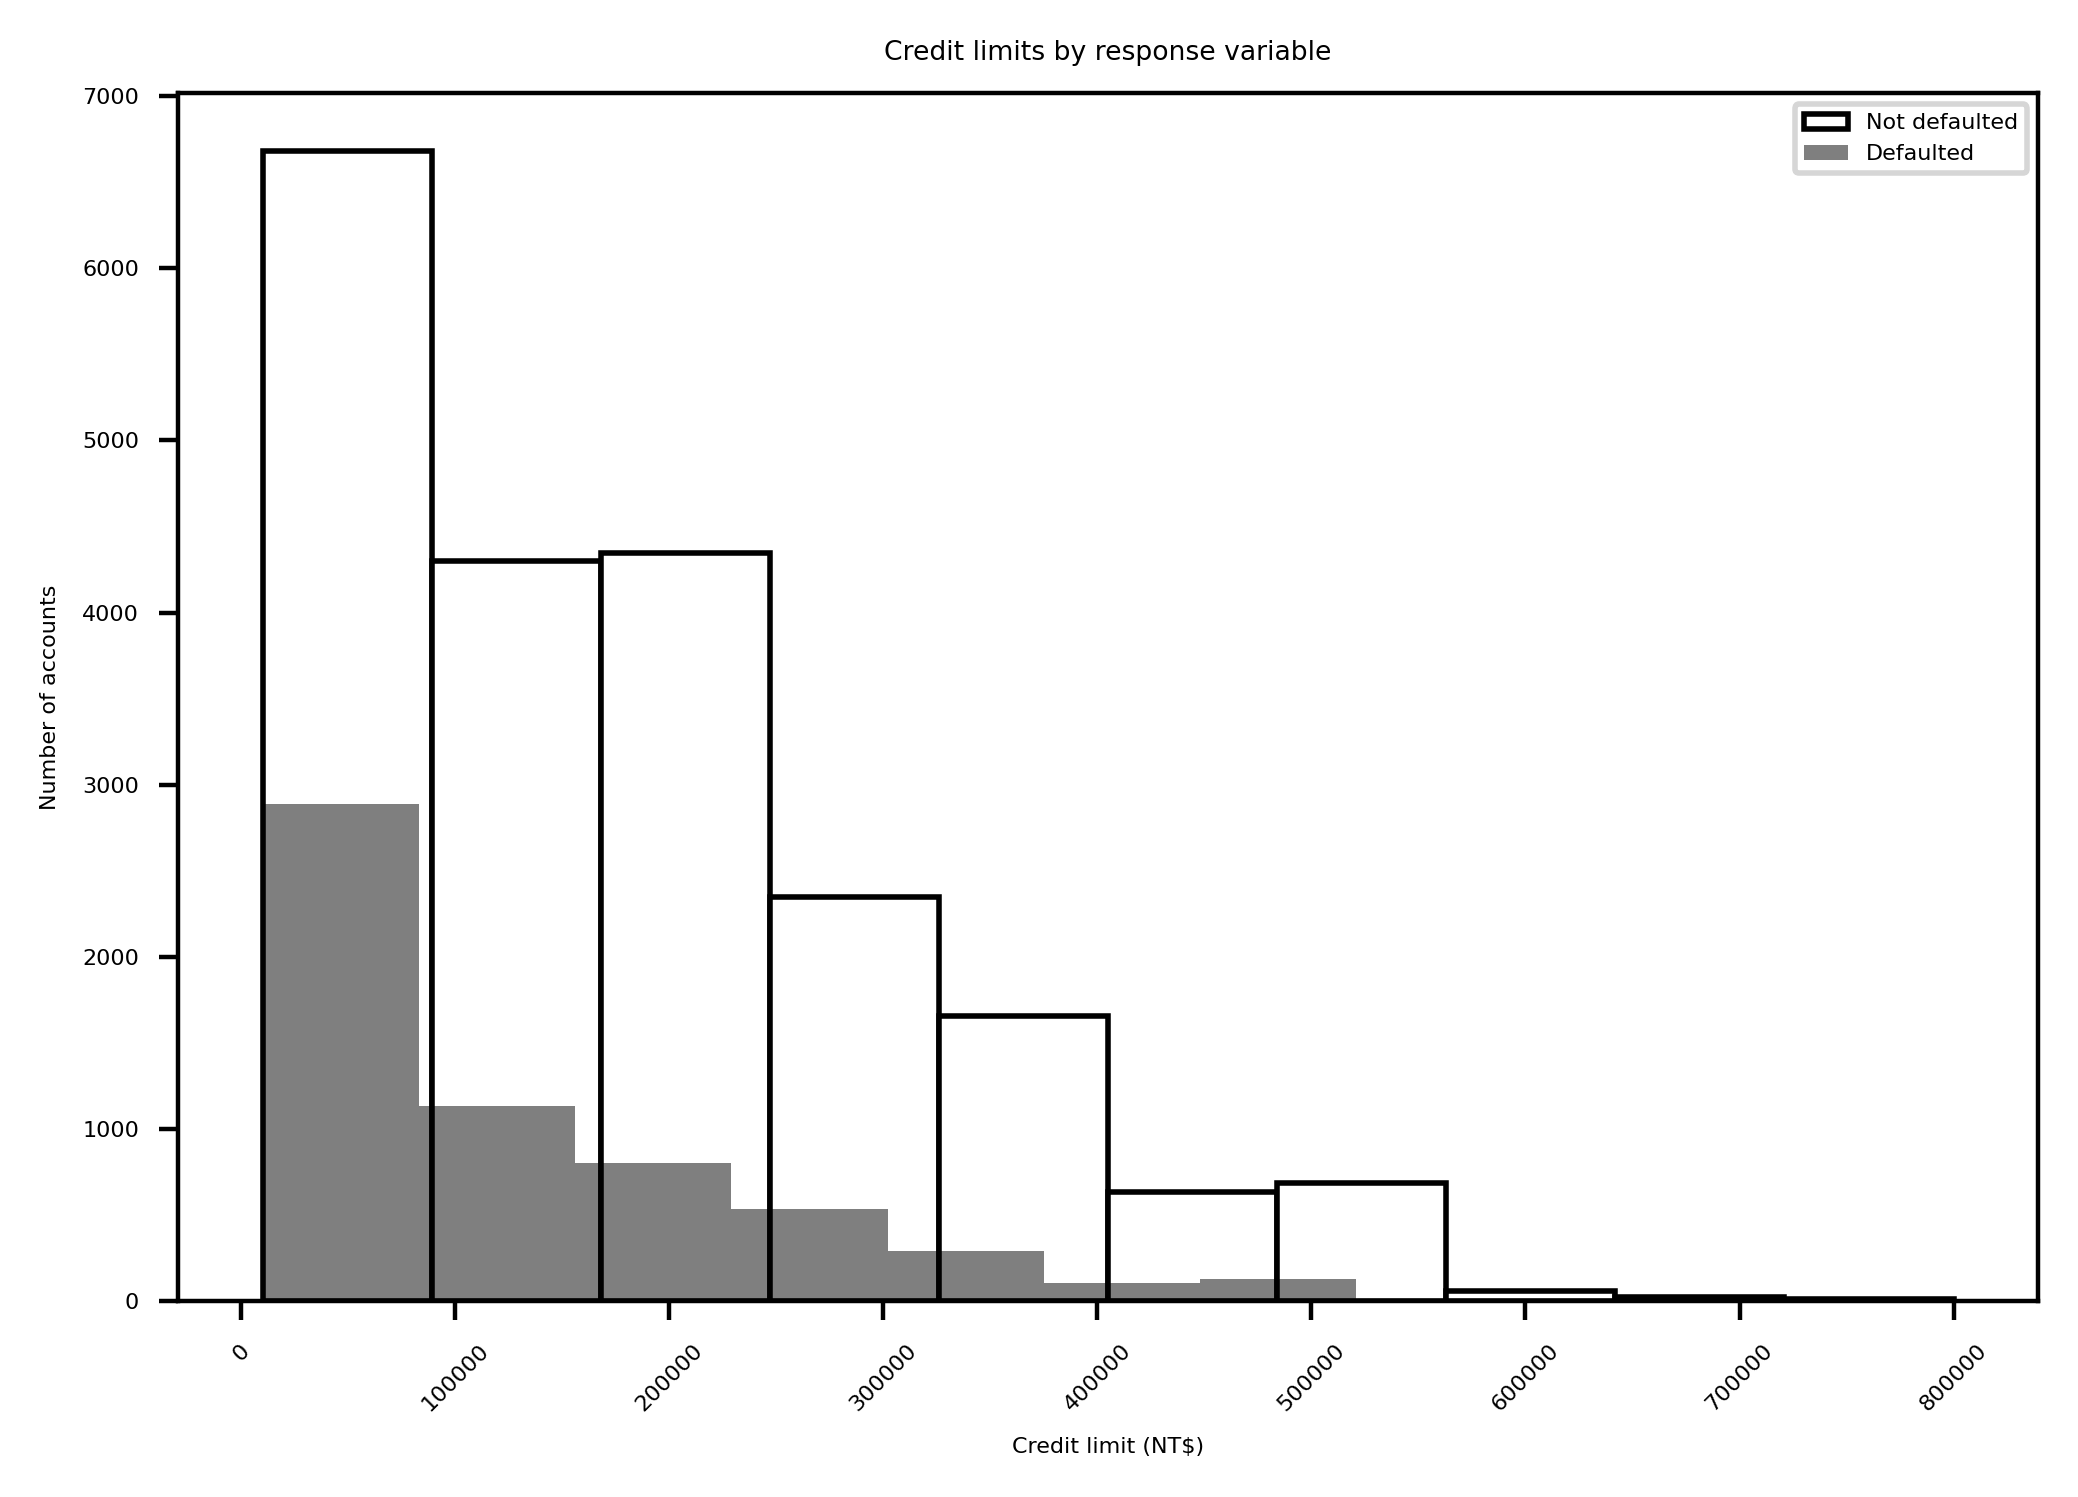

In [155]:
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'],
          edgecolor='black', color='white')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'],
          alpha=0.5, edgecolor=None, color='black')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Number of accounts')
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Credit limits by response variable')

the primary
visual takeaway here is that the transparent histogram is bigger than the gray
one. This is due to the fact that fewer accounts default than don't default. We
already know this from examining the class fractions.

In [156]:
df['LIMIT_BAL'].max()

800000

In [157]:
bin_edges = list(range(0,850000,50000))
print(bin_edges)

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000]


Text(0.5, 1.0, 'Normalized distributions of credit limits by response variable')

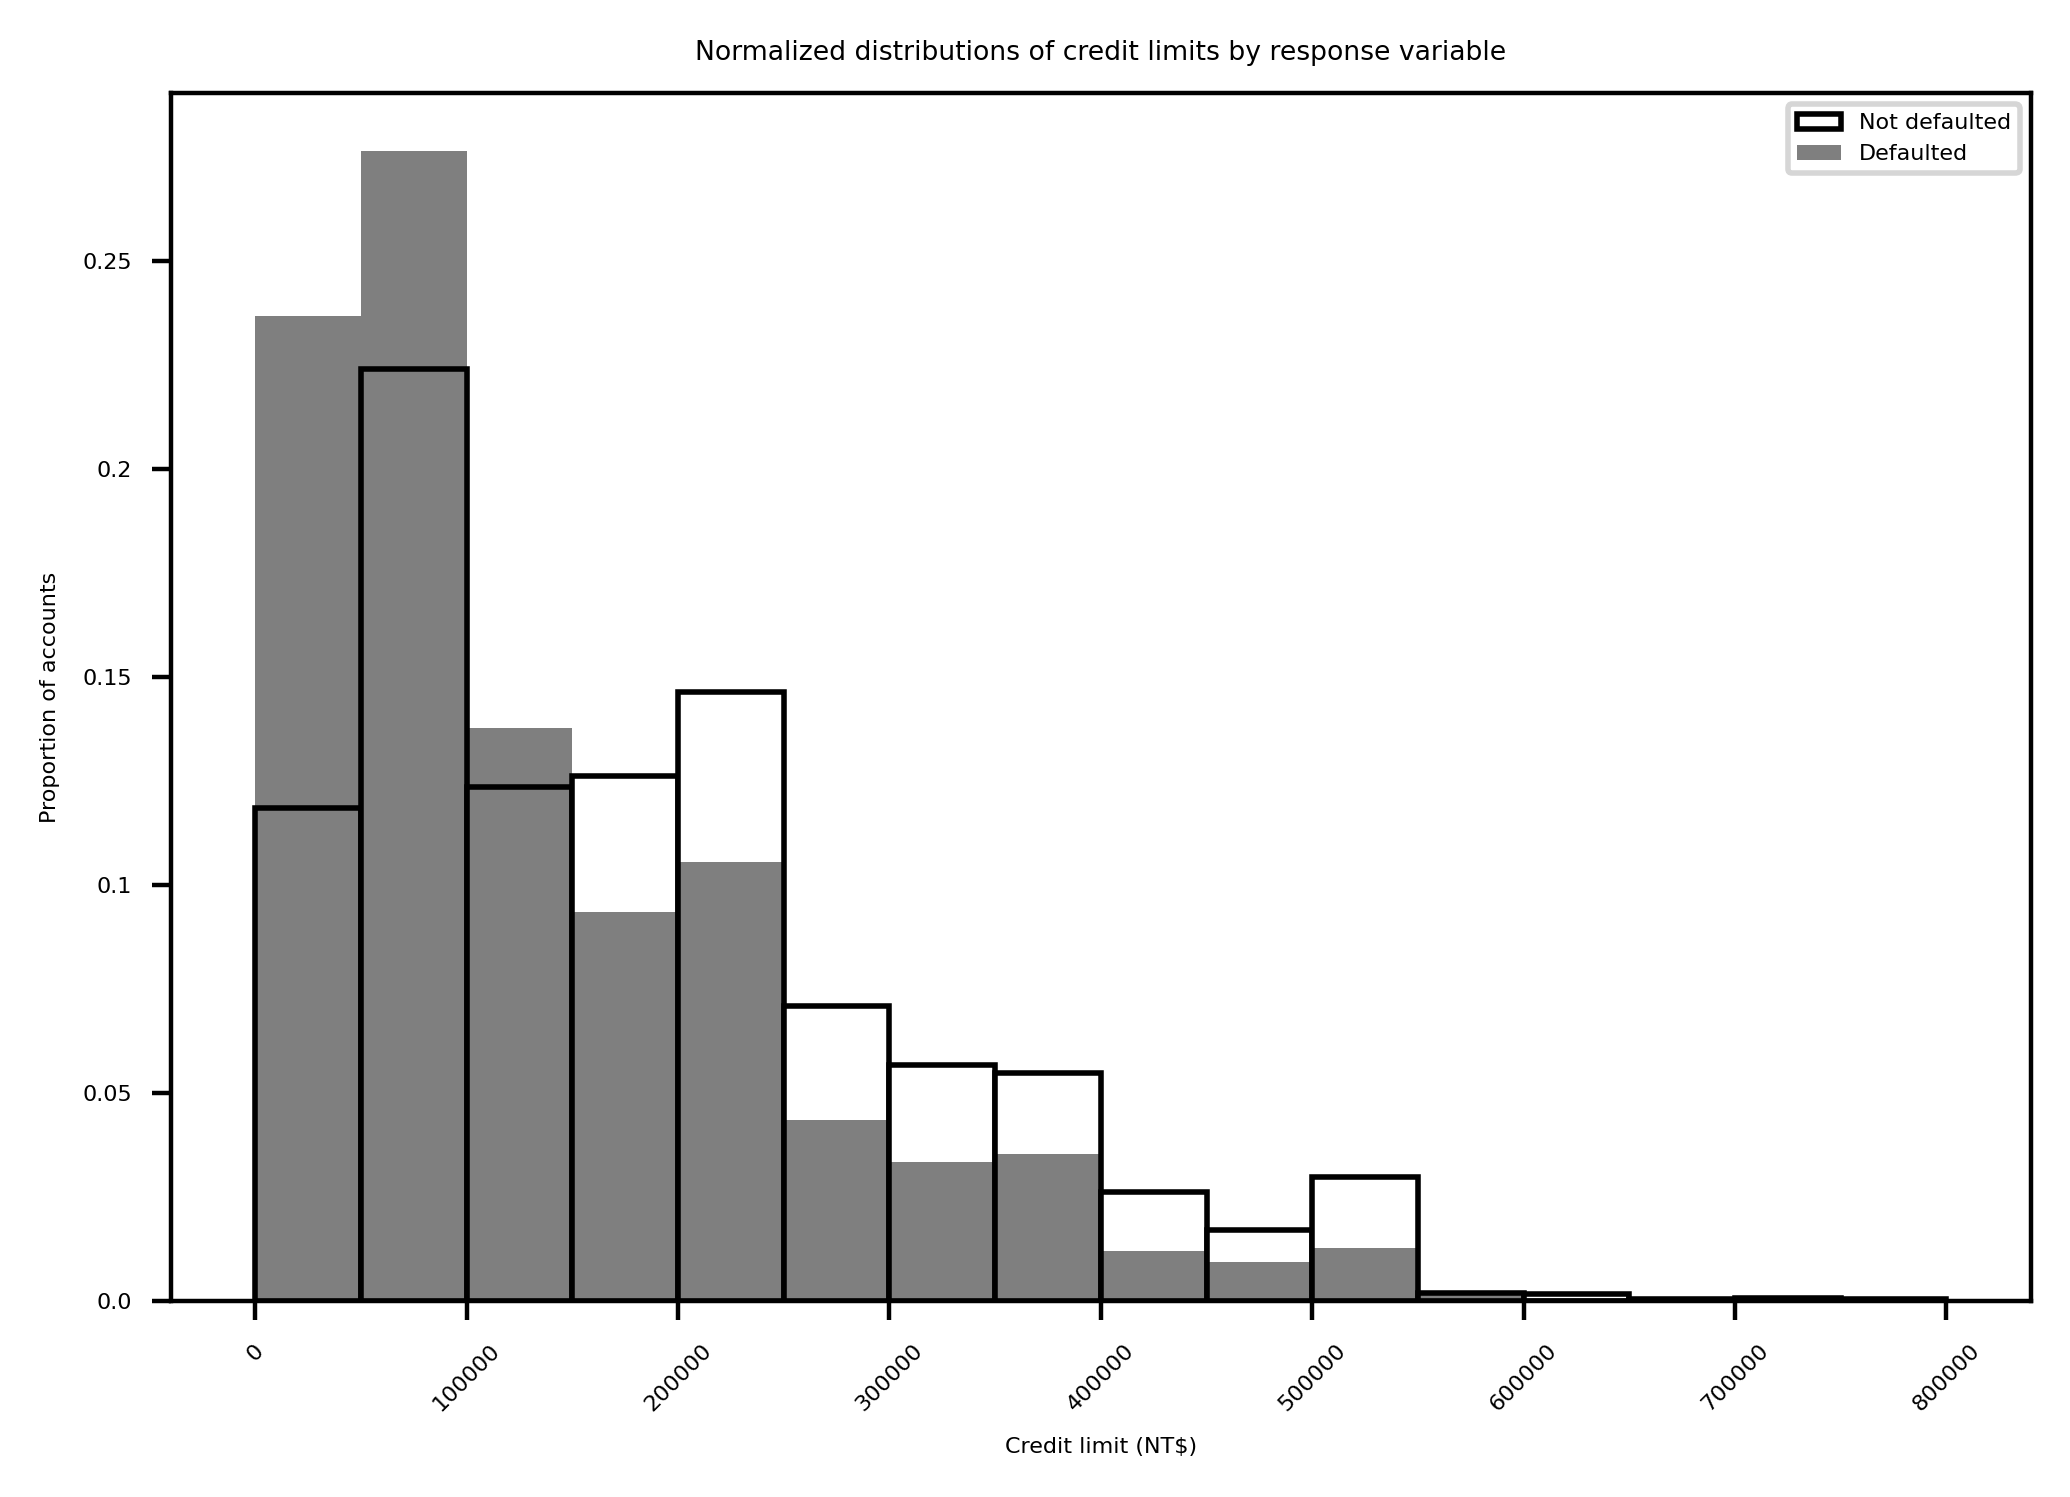

In [158]:
mpl.rcParams['figure.dpi'] = 400 
axes = plt.axes()
axes.hist(
    df.loc[neg_mask, 'LIMIT_BAL'],
    bins=bin_edges, density=True,
    edgecolor='black', color='white')
axes.hist(
    df.loc[pos_mask, 'LIMIT_BAL'],
    bins=bin_edges, density=True, alpha=0.5,
    edgecolor=None, color='black')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Proportion of accounts')
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks*50000,2))
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Normalized distributions of '
               'credit limits by response variable')

? It looks like the accounts that default tend to
have a higher proportion of lower credit limits. Accounts with credit limits less
than NT$150,000 are relatively more likely to default, while the opposite is true for
accounts with limits higher than this. We should ask ourselves, does this make sense?
Our hypothesis was that the client would give riskier accounts lower limits. This
intuition is compatible with the higher proportions of defaulters with lower credit
limits that we observed here.

## **Training and test split**

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [160]:
print(X_train.shape)
print(X_test.shape)

(21331, 17)
(5333, 17)


Model choices
Now we've got our data prepared, we can start to fit models. We'll be using the following and comparing their results.

* Logistic Regression - LogisticRegression()
* RandomForest - RandomForestClassifier()
* Xgboost - XGBClassifier()

In [161]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(), 
          "XGBoost Classifier": xgb.XGBClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [162]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'Logistic Regression': 0.7836114757172323,
 'Random Forest': 0.8184886555409713,
 'XGBoost Classifier': 0.8214888430526908}

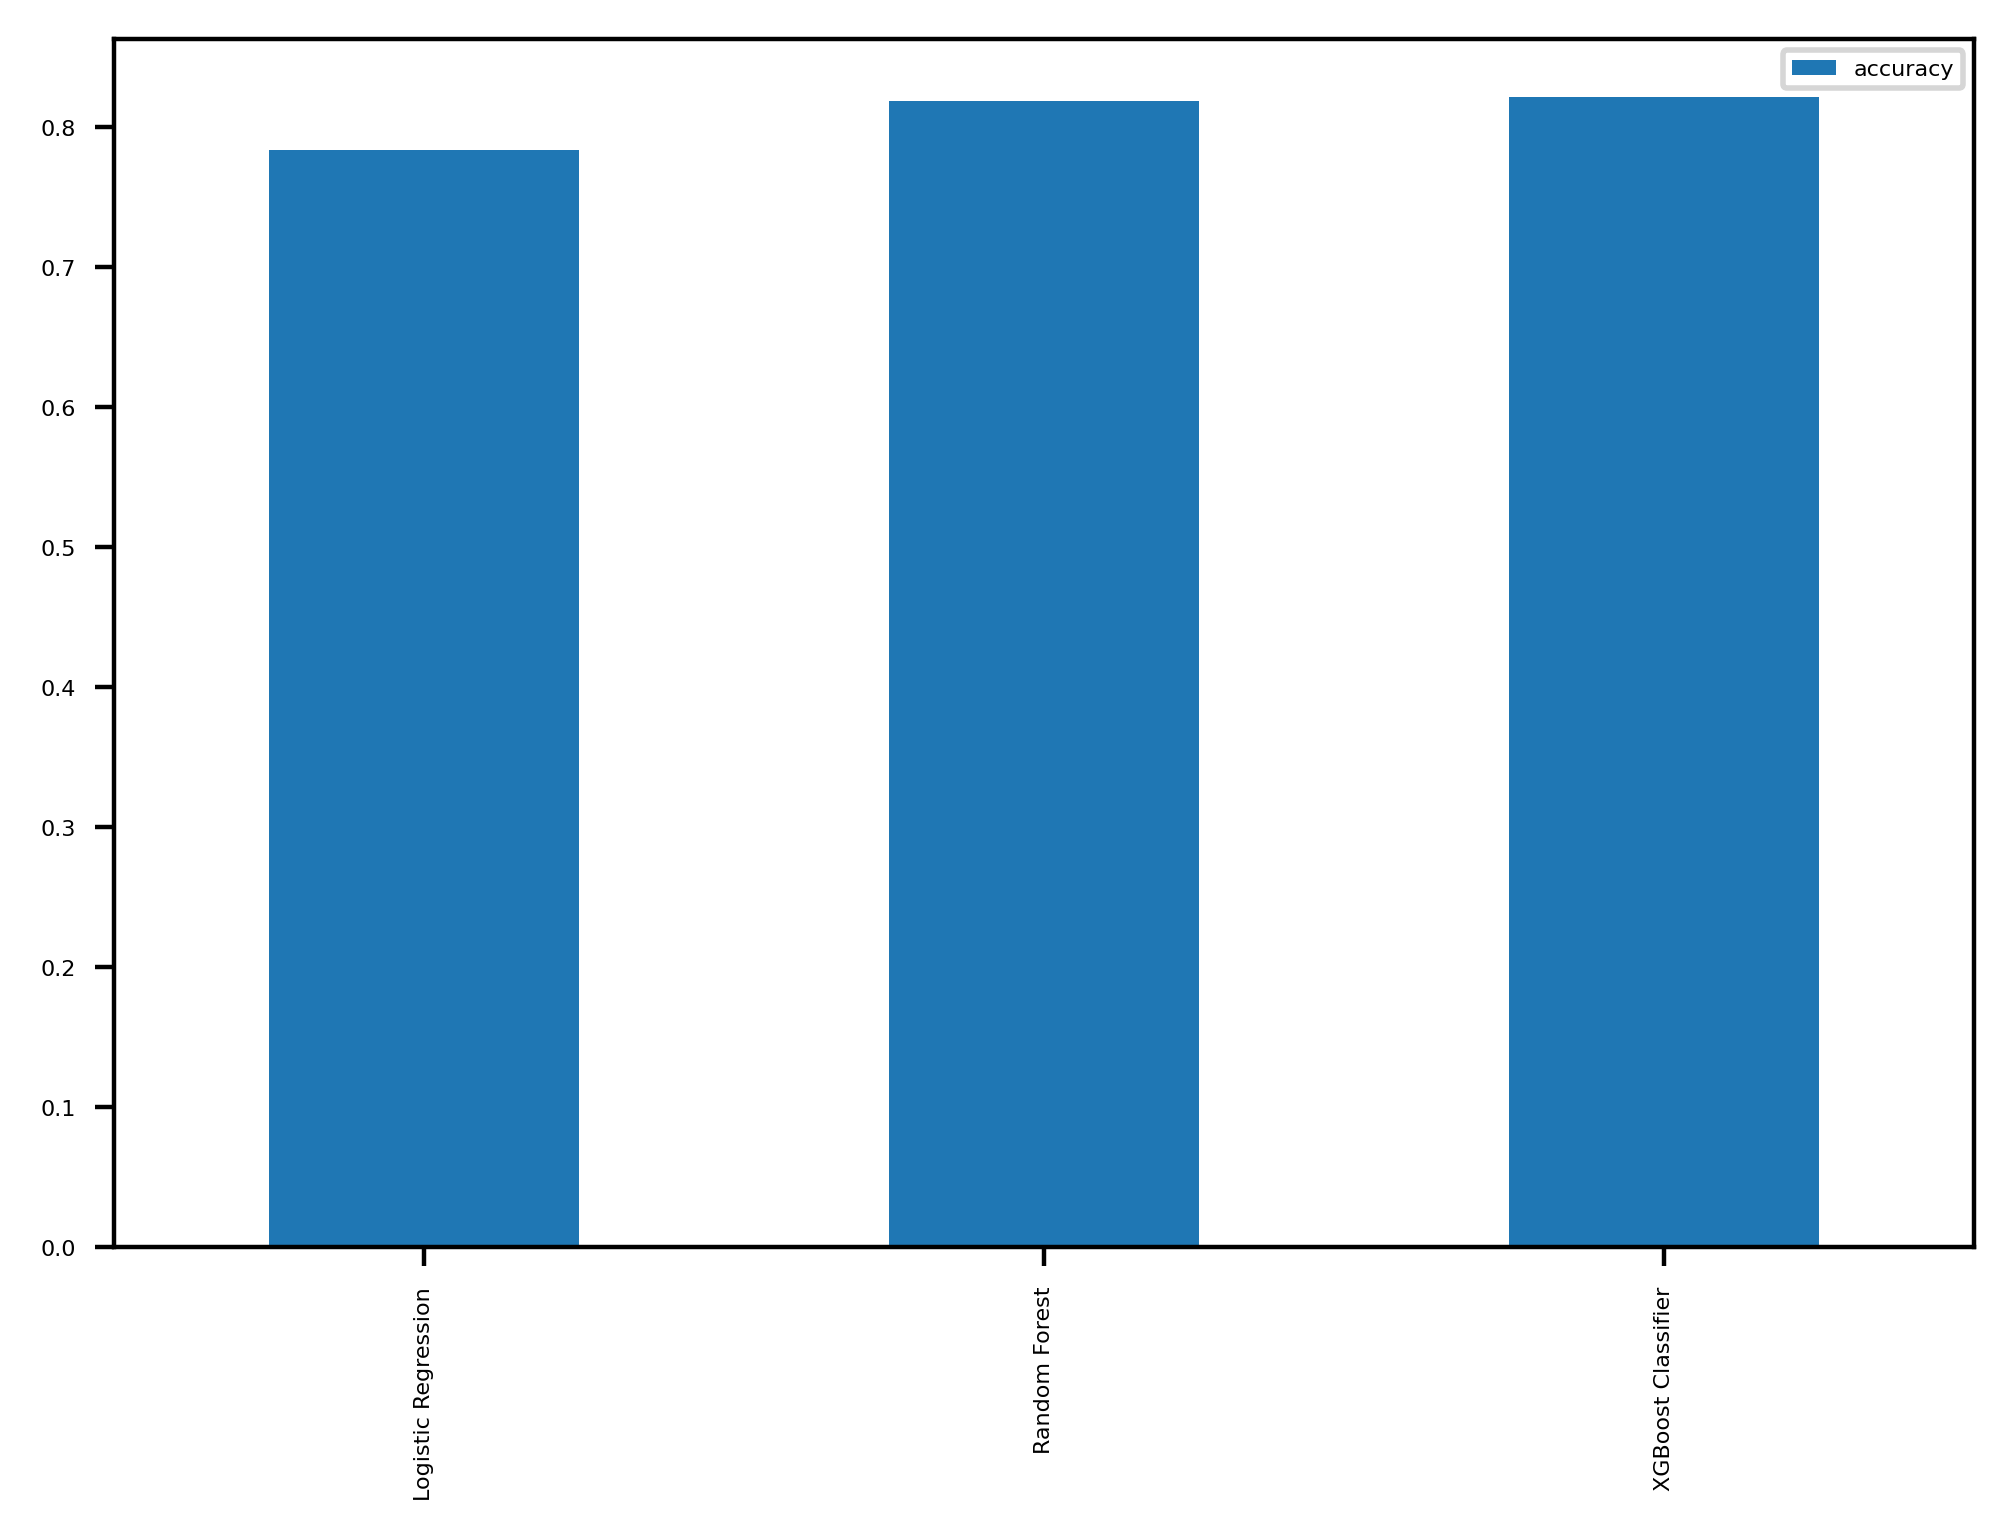

In [163]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

from the graph we can see that all models are closely equally preforming well and XGBoost model performs best out of it.

In [164]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [166]:
np.random.seed(24)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [168]:
rs_log_reg.best_params_

{'C': 0.00026366508987303583, 'solver': 'liblinear'}

In [167]:
rs_log_reg.score(X_test, y_test)

0.7834239639977498

Using RandomizedSearchCV we can see that accuracy is around 0.78

In [169]:
min_max_sc = MinMaxScaler()

In [170]:
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)

In [171]:
lr

LogisticRegression(max_iter=1000, penalty='l1', solver='saga')

In [172]:
scale_lr_pipeline = Pipeline(
    steps=[('scaler', min_max_sc), ('model', lr)])

In [173]:
scale_lr_pipeline.get_params()

{'memory': None,
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False,
 'scaler': MinMaxScaler(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False}

In [174]:
scale_lr_pipeline.set_params(model__C = 2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [175]:
C_val_exponents = np.linspace(2,-3,6)
C_val_exponents

array([ 2.,  1.,  0., -1., -2., -3.])

In [176]:
C_vals = np.float(10)**C_val_exponents
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [177]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()
                                        ['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [178]:
n_folds = 4
k_folds = KFold(n_splits=n_folds, shuffle=False)

In [179]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline,
                        X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: user 14.3 s, sys: 2.36 s, total: 16.7 s
Wall time: 14.5 s


In [180]:
cmap = mpl.cm.get_cmap('tab10')

Text(0.5, 1.0, 'Cross-validation scores for each fold')

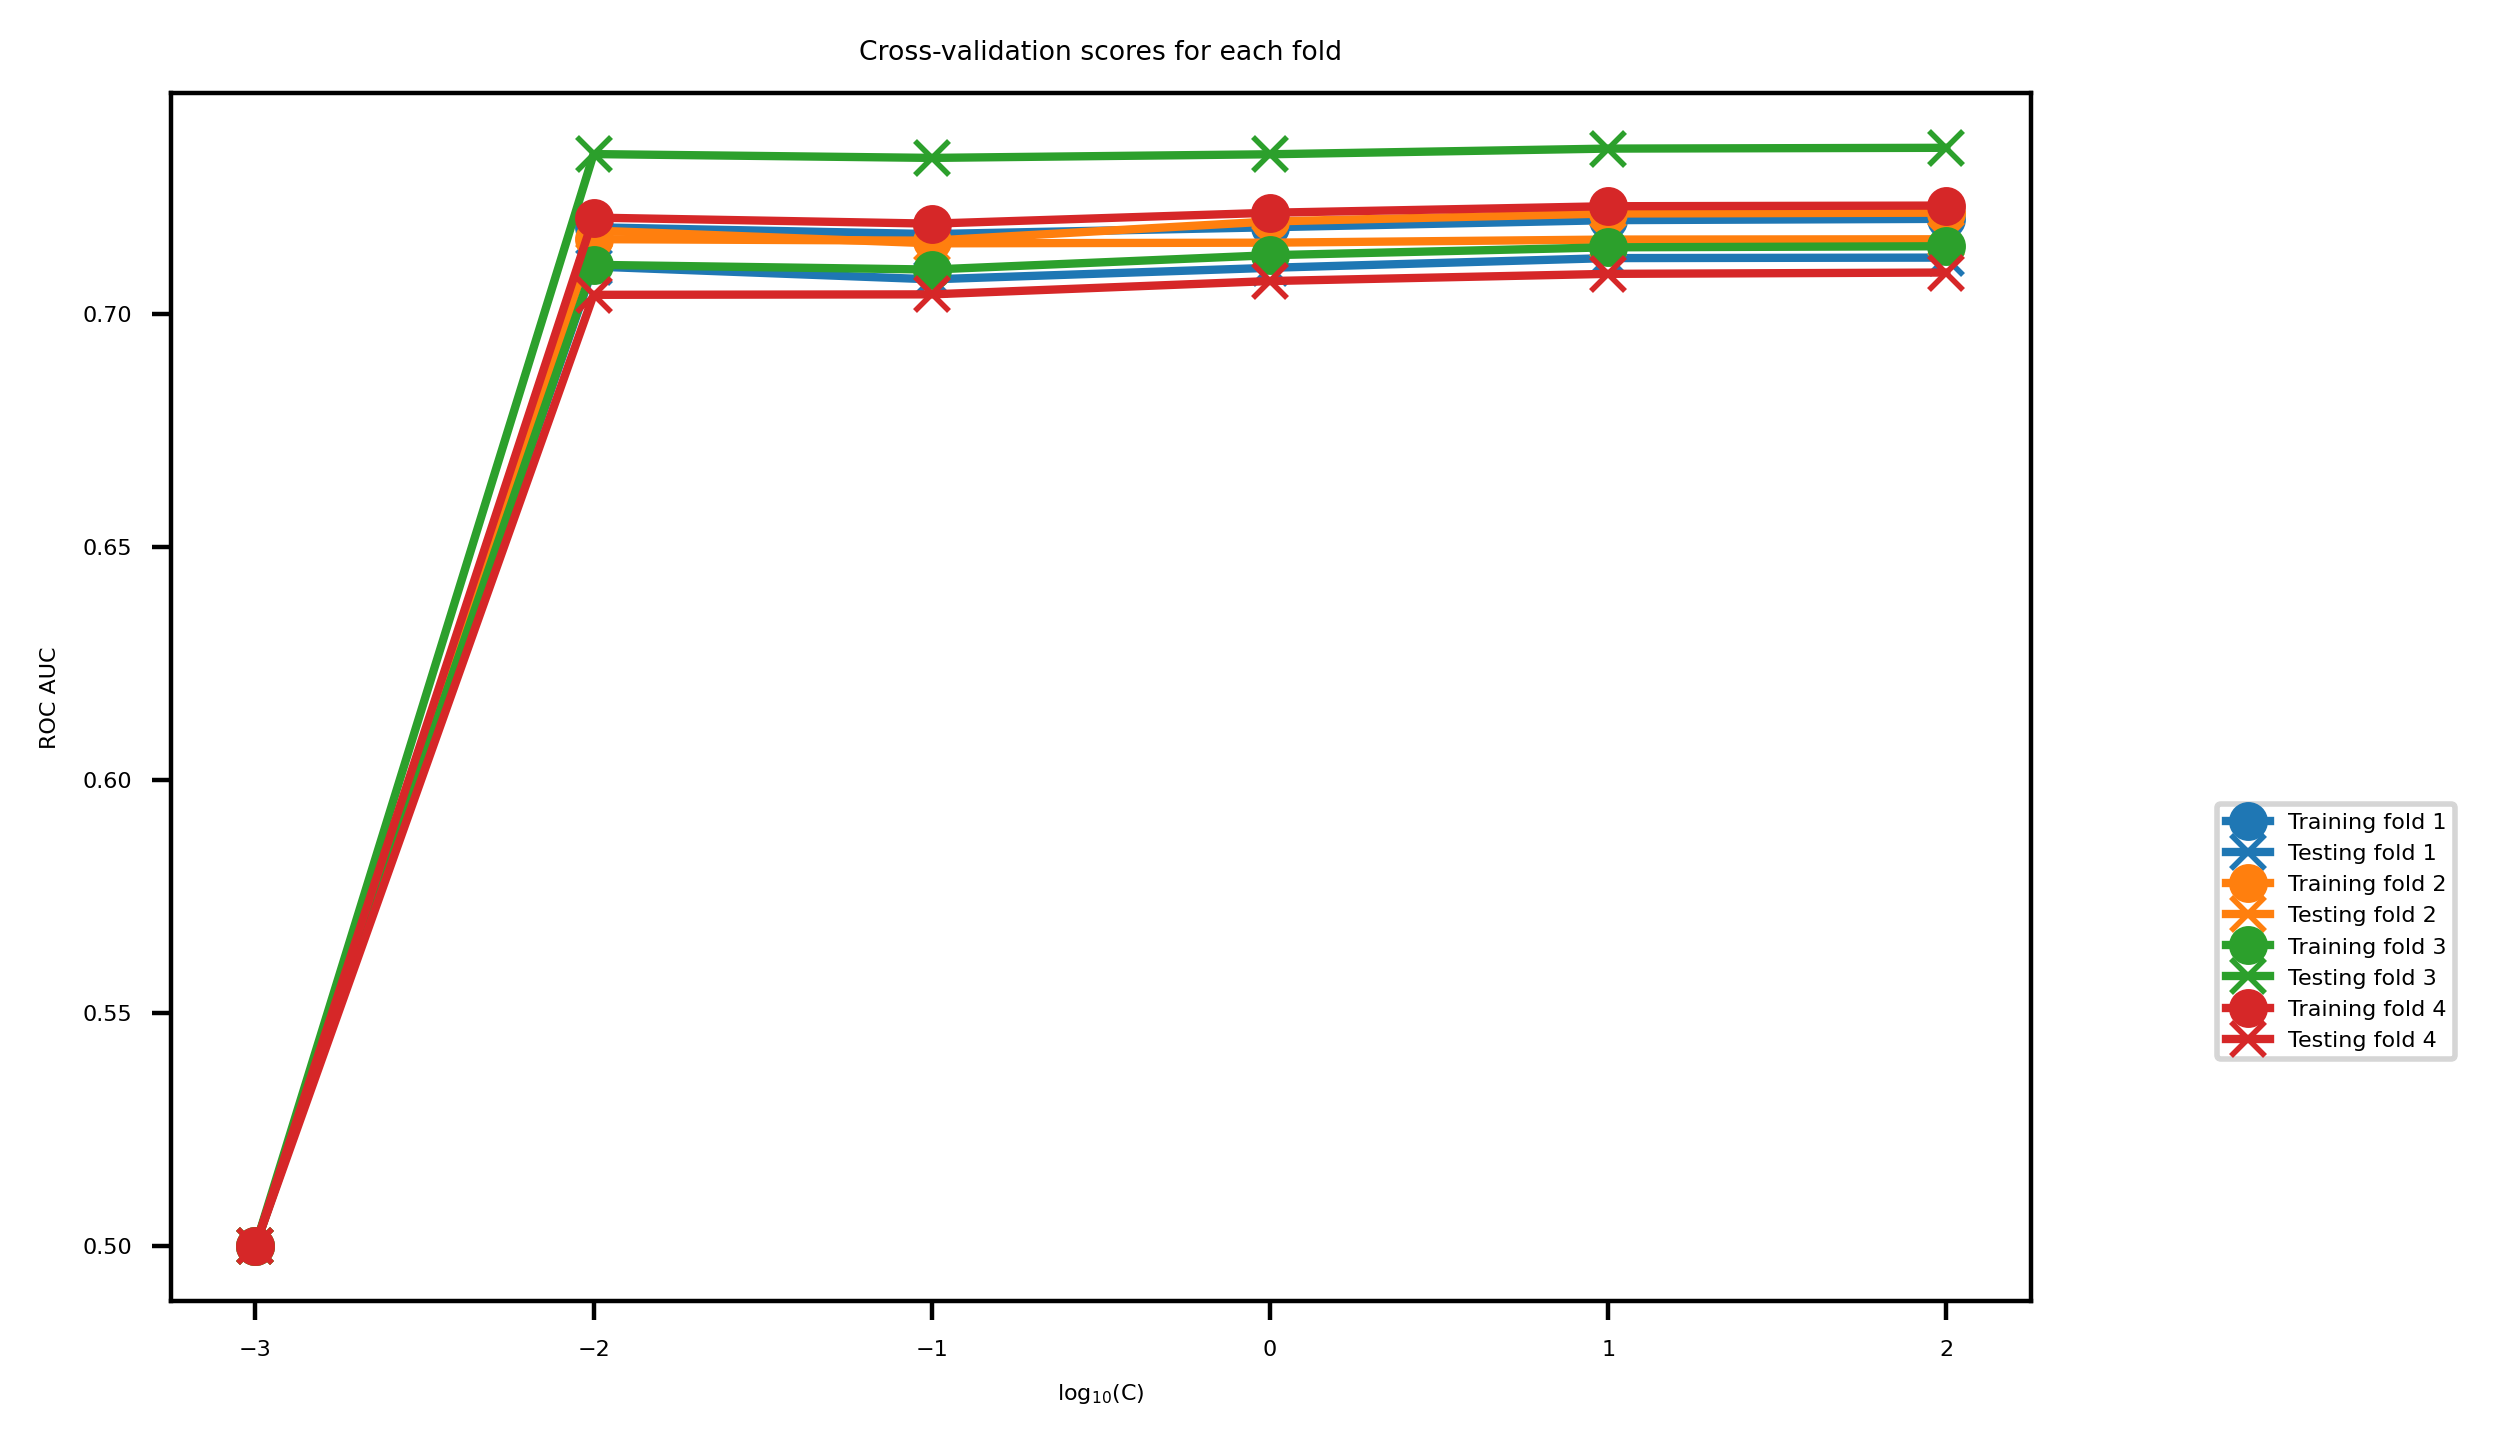

In [181]:
for this_fold in range(k_folds.n_splits):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',
             color=cmap(this_fold),
             label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',
             color=cmap(this_fold),
             label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross-validation scores for each fold')

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

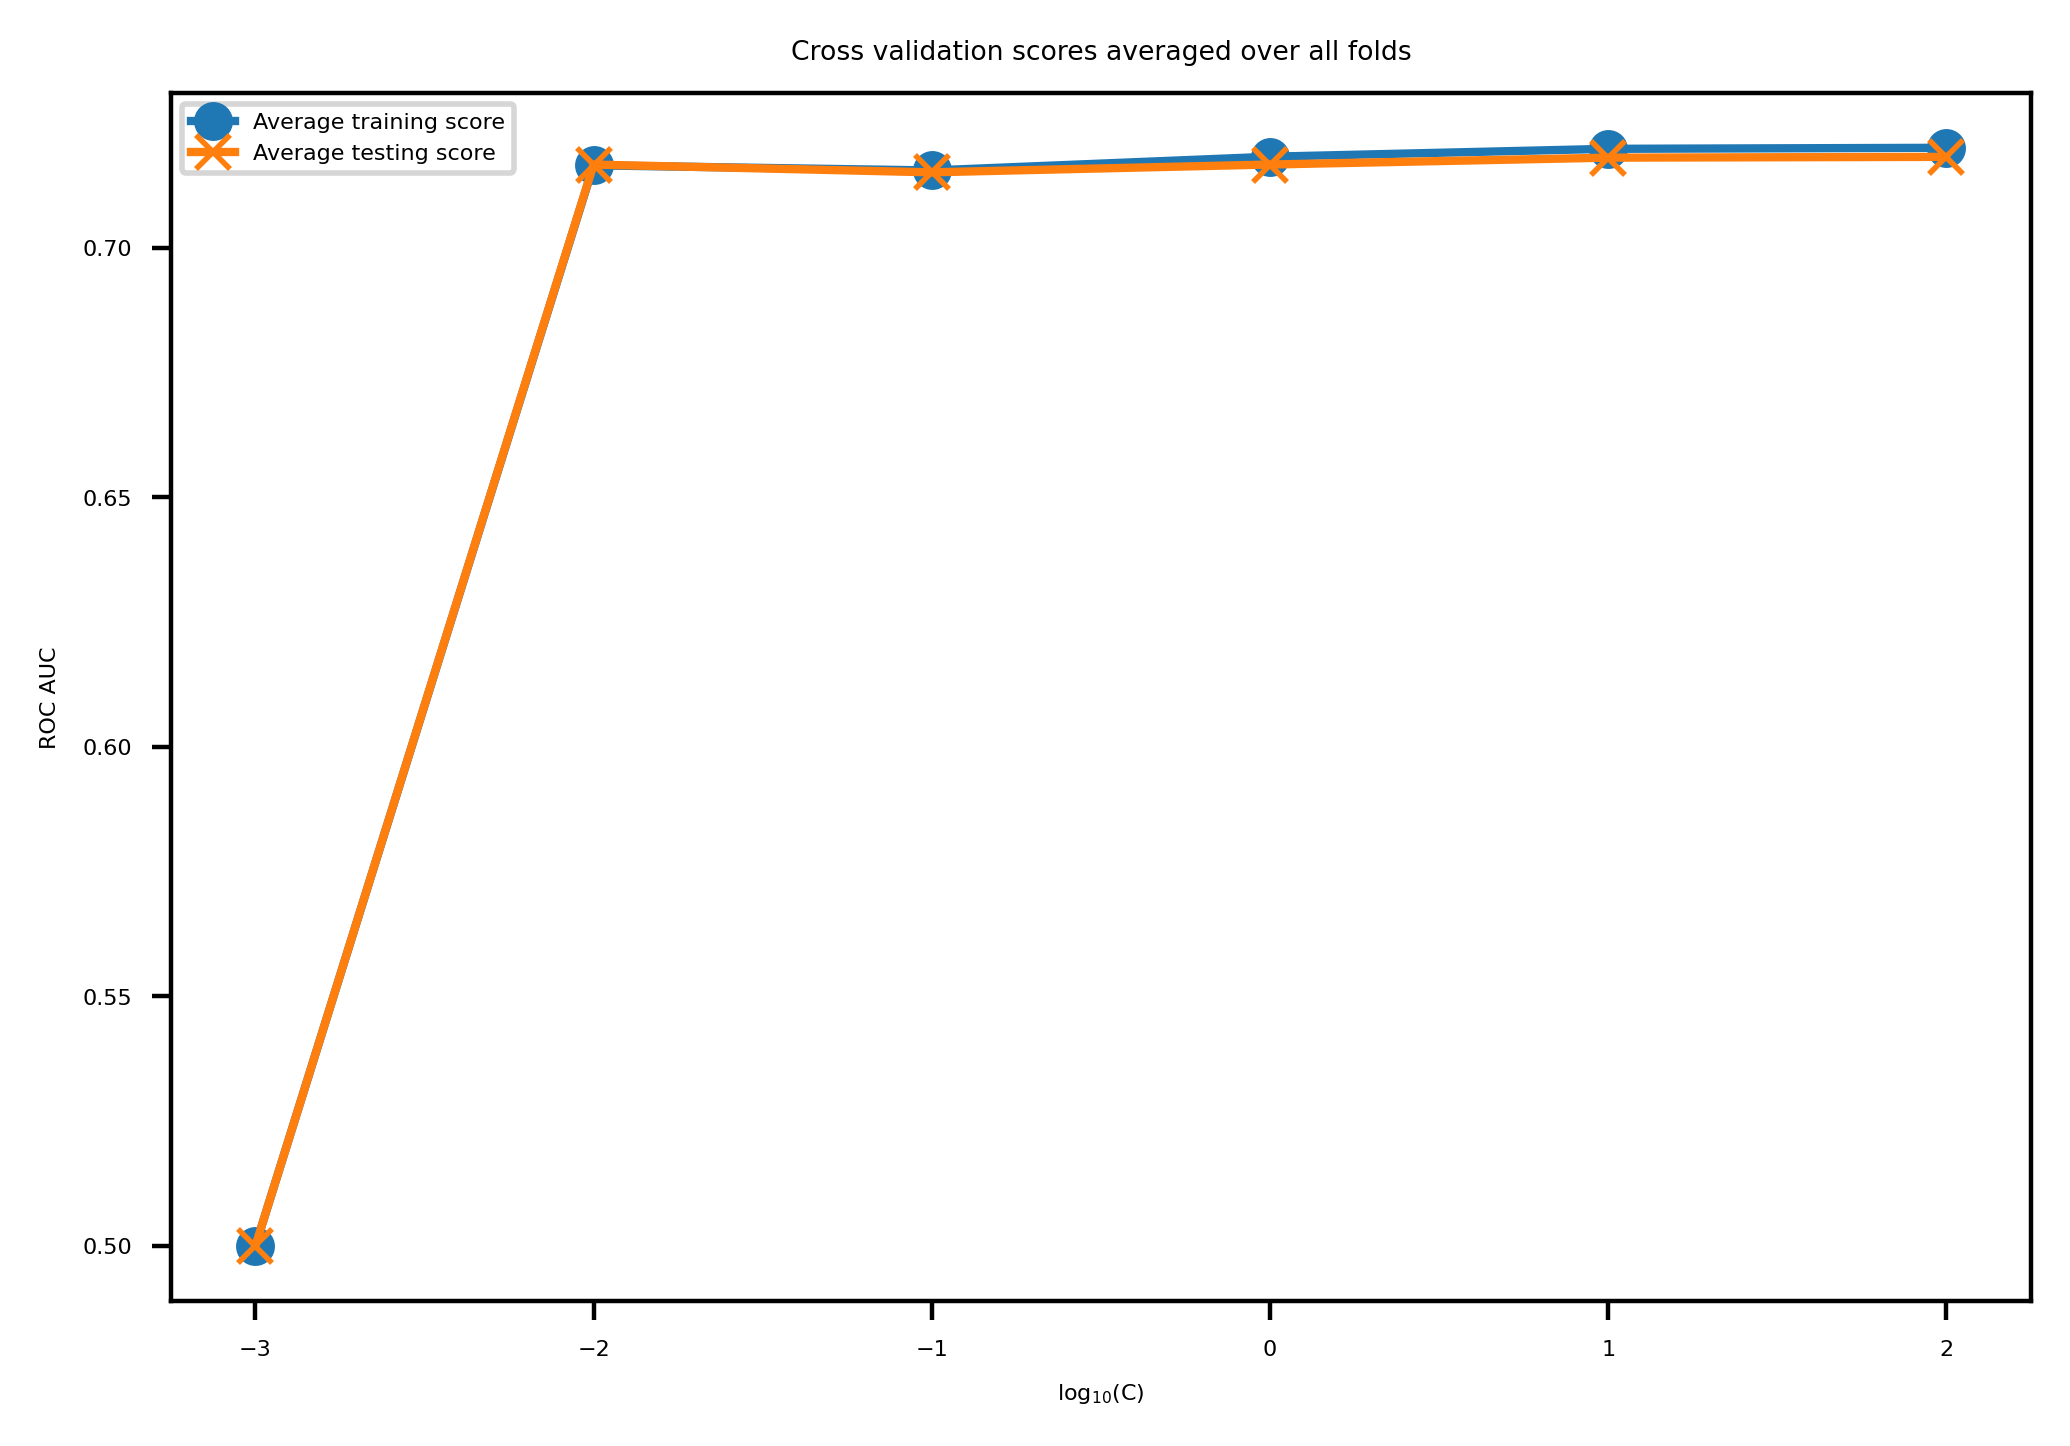

In [182]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0),
         '-o', label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0),
         '-x', label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

We notice that regularization does not impart much benefit here, as may
be expected: for lower C values, which correspond to stronger regularization,
model testing (as well as training) performance decreases. While we are able to
increase model performance over our previous efforts by using all the features
available, it appears there is no overfitting going on. Instead, the training and
test scores are about the same. Instead of overfitting, it's possible that we may

In [183]:
rf_params_ex = {'n_estimators':list(range(10,110,10))}

In [184]:
rf = RandomForestClassifier\
(n_estimators=10, criterion='gini', max_depth=3,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
 bootstrap=True, oob_score=False, n_jobs=None,
random_state=4, verbose=0, warm_start=False, class_weight=None)

In [185]:
# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model
rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [186]:
rs_rf.score(X_test, y_test)

0.8198012375773486

In [187]:
rs_rf_results_df = pd.DataFrame(rs_rf.cv_results_)

In [188]:
rs_rf_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.961138,3.888050,0.206476,0.049557,210,14,13,None,"{'n_estimators': 210, 'min_samples_split': 14,...",0.816264,0.821144,0.818565,0.827473,0.818800,0.820449,0.003837,10
1,20.626699,0.379696,0.415375,0.006415,960,18,5,5,"{'n_estimators': 960, 'min_samples_split': 18,...",0.815327,0.821378,0.819737,0.827239,0.820206,0.820778,0.003827,4
2,3.885258,0.015059,0.068900,0.001559,110,18,13,10,"{'n_estimators': 110, 'min_samples_split': 18,...",0.816030,0.820441,0.819503,0.827239,0.819972,0.820637,0.003649,6
3,2.323779,0.296205,0.037961,0.000186,60,14,7,10,"{'n_estimators': 60, 'min_samples_split': 14, ...",0.816030,0.817159,0.819503,0.827473,0.817862,0.819605,0.004092,15
4,19.941881,0.034362,0.348388,0.006037,560,8,11,10,"{'n_estimators': 560, 'min_samples_split': 8, ...",0.816030,0.819972,0.819972,0.825363,0.821613,0.820590,0.003013,7
5,0.210728,0.006079,0.005878,0.000083,10,8,19,5,"{'n_estimators': 10, 'min_samples_split': 8, '...",0.805484,0.816221,0.812002,0.821144,0.817862,0.814543,0.005402,17
6,35.045841,7.392067,0.535663,0.004904,560,16,1,None,"{'n_estimators': 560, 'min_samples_split': 16,...",0.817905,0.819737,0.819269,0.827004,0.817862,0.820355,0.003406,11
7,3.008558,0.022017,0.077978,0.000580,210,10,1,3,"{'n_estimators': 210, 'min_samples_split': 10,...",0.809702,0.811533,0.807079,0.800985,0.806142,0.807088,0.003598,19
8,31.049872,0.110834,0.528223,0.003237,560,18,1,None,"{'n_estimators': 560, 'min_samples_split': 18,...",0.817436,0.818331,0.820675,0.826301,0.817393,0.820027,0.003356,14
9,0.215564,0.004488,0.006551,0.001117,10,16,3,5,"{'n_estimators': 10, 'min_samples_split': 16, ...",0.813921,0.809423,0.820910,0.822785,0.819737,0.817355,0.004950,16


In [189]:
rs_rf_results_df.max()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


mean_fit_time              35.045841
std_fit_time                7.392067
mean_score_time             0.562005
std_score_time              0.049557
param_n_estimators               960
param_min_samples_split           18
param_min_samples_leaf            19
param_max_depth                   10
split0_test_score           0.818139
split1_test_score           0.821378
split2_test_score           0.821378
split3_test_score           0.828411
split4_test_score           0.822316
mean_test_score             0.821246
std_test_score              0.007993
rank_test_score                   20
dtype: object

In [190]:
feat_imp_df_act = pd.DataFrame({
    'Feature name':features_response[:-1],
    'Importance':rs_rf.best_estimator_.feature_importances_
})

In [192]:
feat_imp_df_act.sort_values('Importance', ascending=False)

,Feature name,Importance
4,PAY_1,0.249911
5,BILL_AMT1,0.060758
0,LIMIT_BAL,0.060110
11,PAY_AMT1,0.060011
12,PAY_AMT2,0.057321
6,BILL_AMT2,0.055467
7,BILL_AMT3,0.053244
13,PAY_AMT3,0.051509
8,BILL_AMT4,0.050084
10,BILL_AMT6,0.049199


Notice that the top
five most important features from the random forest are the same as the top
five chosen by an ANOVA F-test.This is good
confirmation between the different methods.


In [198]:
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    learning_rate=0.1,
    verbosity=1,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    tree_method='hist',
    grow_policy='lossguide')

In [199]:
max_leaves_values = list(range(5,205,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[180, 185, 190, 195, 200]


In [200]:
from sklearn.model_selection import train_test_split
X_train_2, X_val_2, y_train_2, y_val_2 = \
train_test_split(X_train, y_train, test_size=0.2, random_state=24)

In [201]:
eval_set_2 = [(X_train_2, y_train_2), (X_val_2, y_val_2)]

In [203]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
    #Set parameter and fit model
    xgb_model.set_params(**{'max_leaves':max_leaves})
    xgb_model.fit(X_train_2, y_train_2, eval_set=eval_set_2,
                  eval_metric='auc',
                  verbose=False, early_stopping_rounds=30)
    
    #Get validation score
    val_set_pred_proba = xgb_model.predict_proba(X_val_2)[:,1]
    val_aucs.append(roc_auc_score(y_val_2, val_set_pred_proba))

CPU times: user 1min 2s, sys: 708 ms, total: 1min 3s
Wall time: 1min 3s


In [204]:
max_leaves_df_2 = \
pd.DataFrame({'Max leaves':max_leaves_values,
              'Validation AUC':val_aucs})

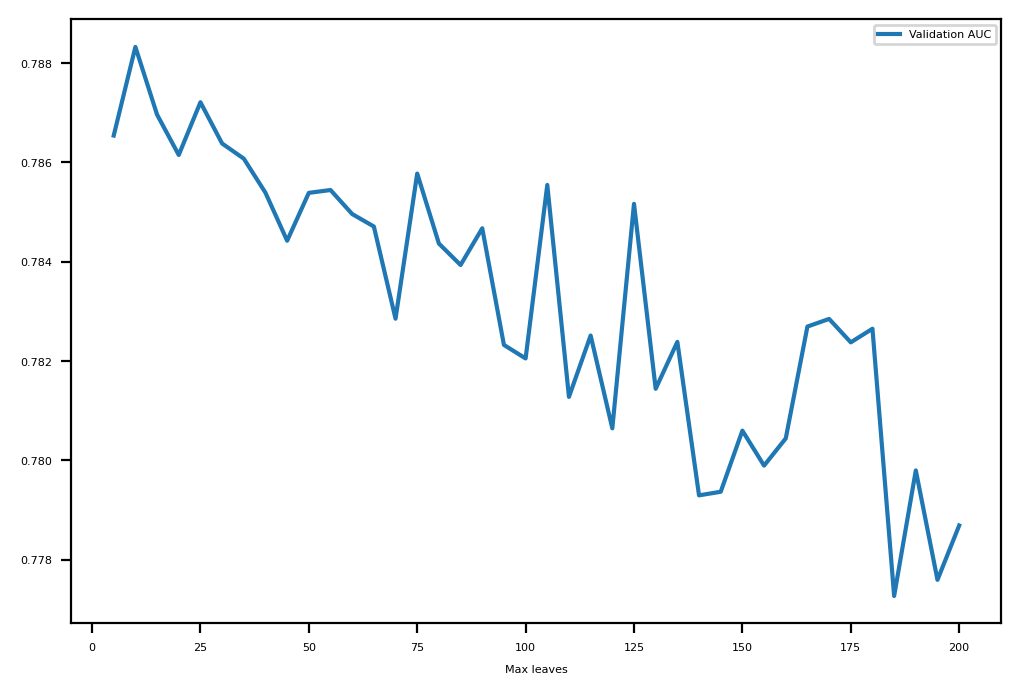

In [205]:
mpl.rcParams['figure.dpi'] = 200
max_leaves_df_2.set_index('Max leaves').plot()

Although the relationship is somewhat noisy, we see that in general, lower
values of max_leaves result in a higher validation set ROC AUC. This is
because limiting the complexity of trees by allowing fewer leaves results in less
overfitting, and increases the validation set score.

In [206]:
max_auc_2 = max_leaves_df_2['Validation AUC'].max()
max_auc_2

0.788328454789269

In [207]:
max_ix_2 = max_leaves_df_2['Validation AUC'] == max_auc_2
max_leaves_df_2[max_ix_2]

,Max leaves,Validation AUC
1,10,0.788328


However, even given these limitations, the validation results here should provide
a measure of out-of-sample performance similar to the k-folds cross-validation
we performed earlier.
These validation scores are fairly similar and it would
probably be fine to use either model in practice. We'll now move forward with
the XGBoost model.

In [208]:
xgb_model.set_params(**{'max_leaves':40})
xgb_model.fit(X_train_2, y_train_2, eval_set=eval_set_2,
              eval_metric='auc',
              verbose=False, early_stopping_rounds=30)

XGBClassifier(grow_policy='lossguide', max_depth=0, max_leaves=40,
              n_estimators=1000, n_jobs=-1, tree_method='hist',
              use_label_encoder=False)

In [209]:
X_val_2_df = pd.DataFrame(data=X_val_2, columns=features_response[:-1])

SHAP summary

In [211]:
%time explainer_2 = shap.explainers.Tree(xgb_model, data=X_val_2_df)

CPU times: user 215 ms, sys: 973 µs, total: 216 ms
Wall time: 239 ms


In [212]:
%time shap_values_2 = explainer_2(X_val_2_df)

CPU times: user 7.97 s, sys: 31.8 ms, total: 8 s
Wall time: 8.03 s


In [213]:
shap_values_2.values.shape

(4267, 17)

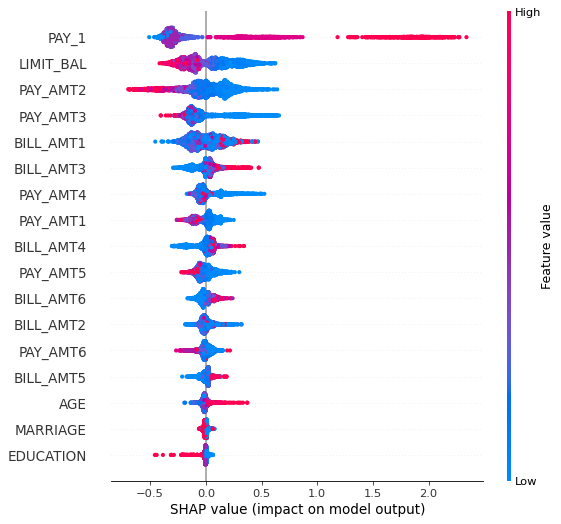

CPU times: user 1.22 s, sys: 575 ms, total: 1.79 s
Wall time: 1.15 s


In [214]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values_2.values, X_val_2_df)

We can see that the most important features in the XGBoost model are somewhat similar from those of other model. PAY_1 is the most important feature followed by credit LIMIT_BALL. This makes sense as an important feature as the lender has likely based
the credit limit on how risky a borrower is, so it should be a good predictor of the
risk of default

Exploring whether LIMIT_BAL has any interesting SHAP interactions with
other features.

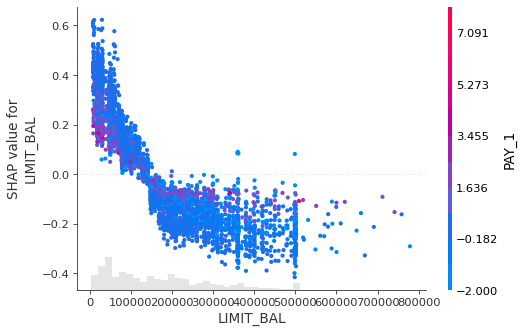

In [215]:
#Use the feature of SHAP that looks for the strongest interaction effect.

shap.plots.scatter(shap_values_2[:,'LIMIT_BAL'],
                   color=shap_values_2)

Finally, we will save the model along with the training and test data for analysis
and delivery to our business partner.

In [217]:
with open('xgb_model_w_data.pkl', 'wb') as f:
    pickle.dump([features_response,
                 X_train, y_train,
                 X_test, y_test,
                 xgb_model], f)

In [220]:
with open('xgb_model_w_data.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all, X_test_all,\
    y_test_all, xgb_model = pickle.load(f)

In [221]:
test_set_pred_proba = xgb_model.predict_proba(X_test_all)[:,1]

In [222]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test_all, test_set_pred_proba)
test_auc

0.7758990092403208

The ROC AUC on the test set is a bit lower than the train set. we saw on the
validation set for the XGBoost model; however, it is not very different. Since the
model fitting process optimized the model for performance on the validation set,
it's not totally surprising to see somewhat lower performance on new data. Overall,
the testing performance is in line with expectations and we can consider this model
successfully tested in terms of the ROC AUC metric.

### **Distribution of Predicted Probability and Decile Chart**

In [223]:
test_set_pred_proba.shape

(5333,)

Text(0, 0.5, 'Number of samples')

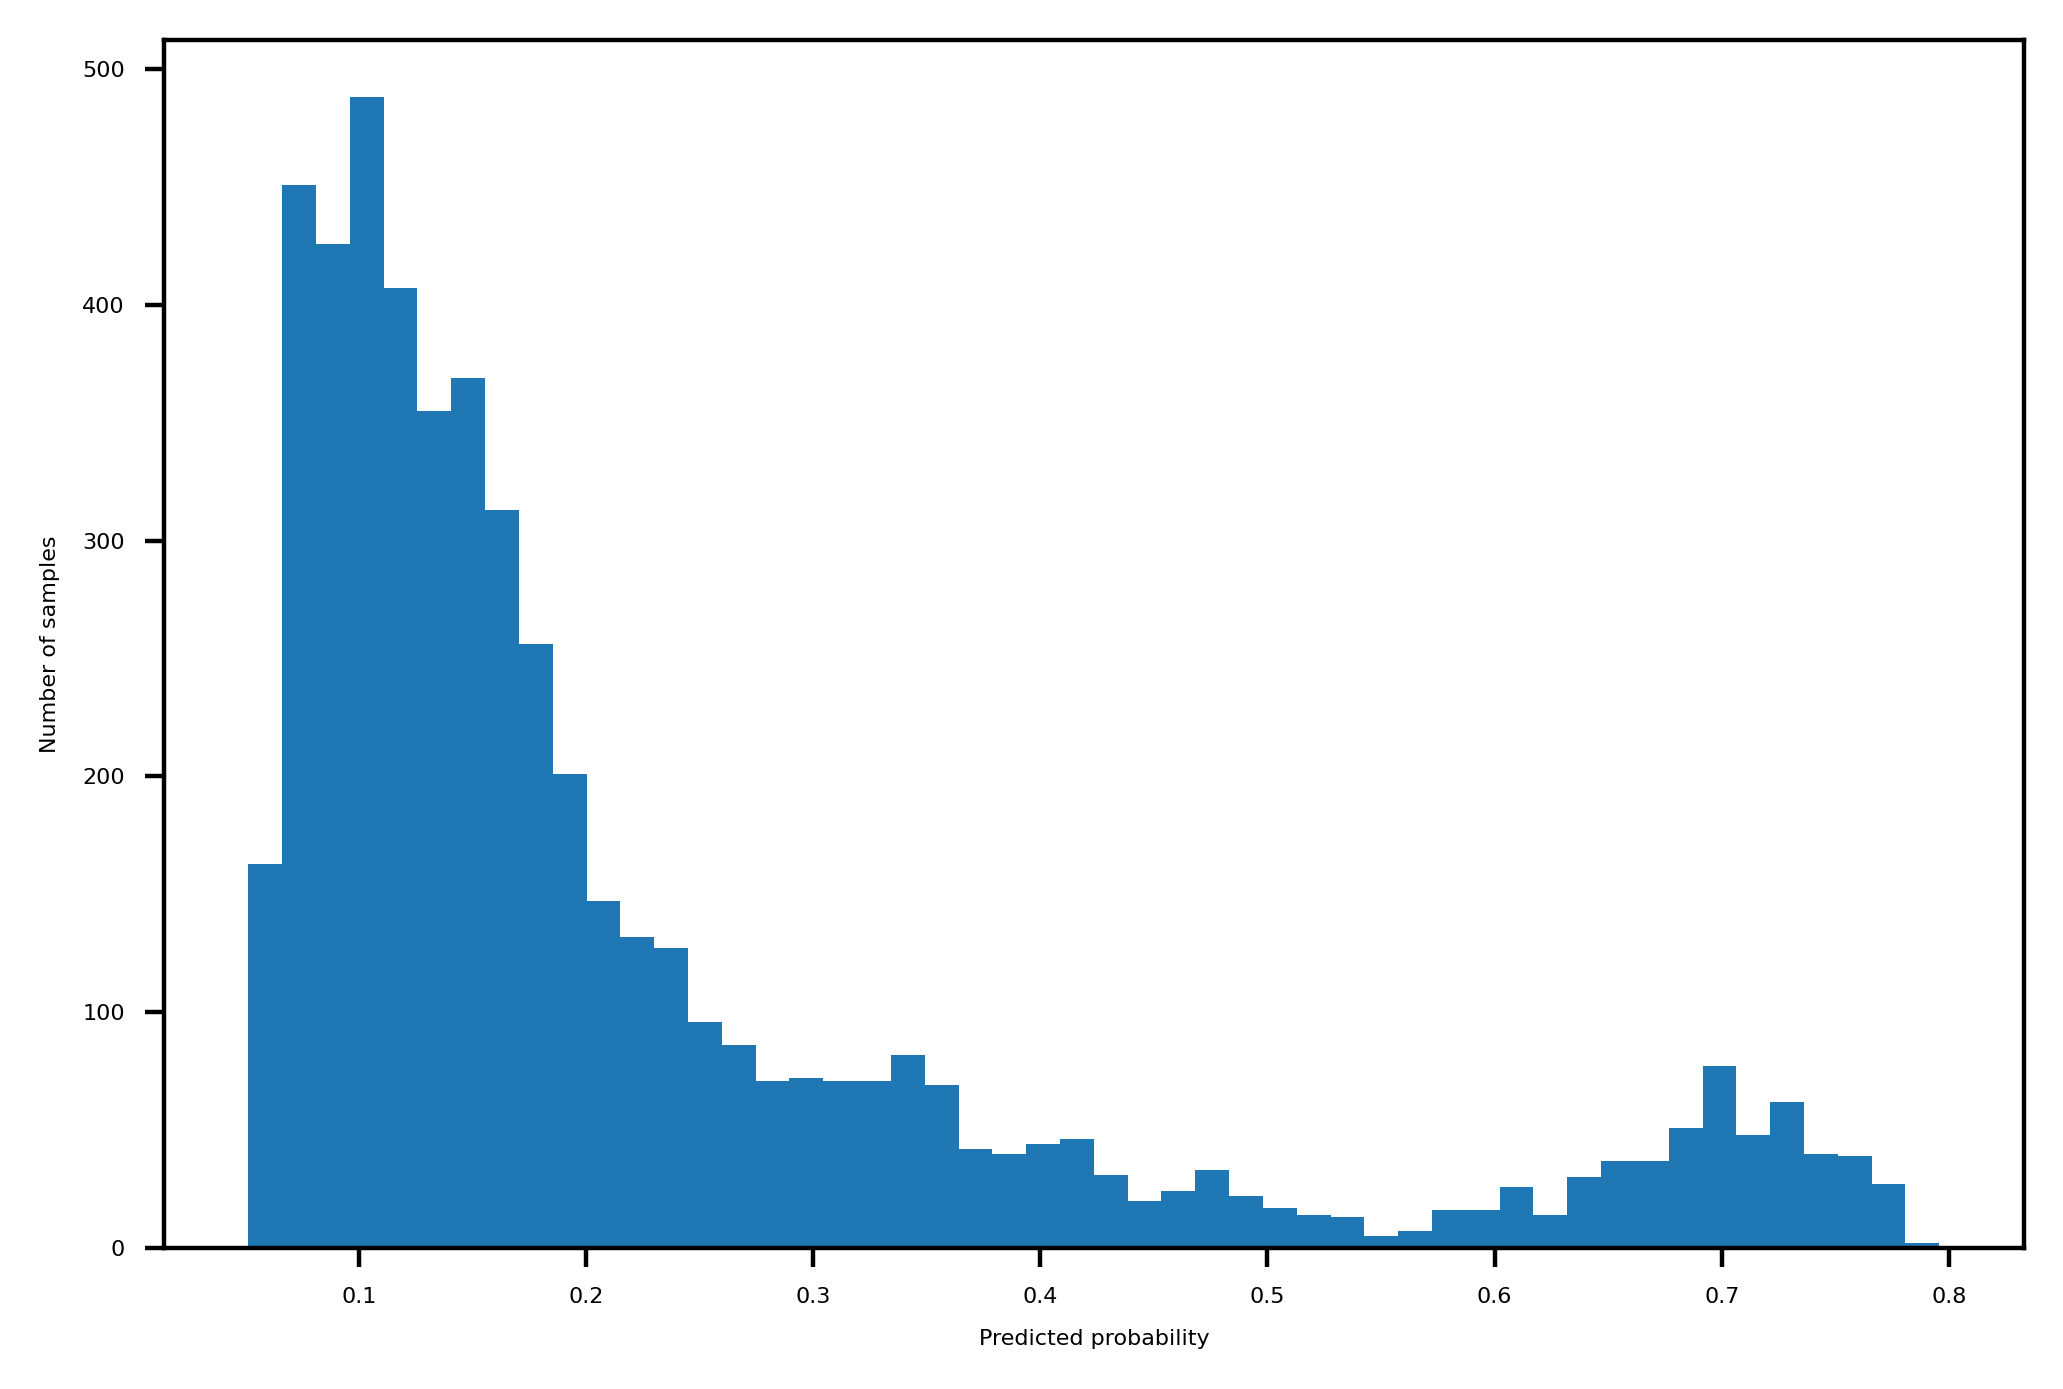

In [224]:
mpl.rcParams['figure.dpi'] = 400
plt.hist(test_set_pred_proba, bins=50)
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')

The histogram of predicted probabilities for the test set shows that most predictions
are clustered in the range [0, 0.2]. In other words, most borrowers have between
a 0 and 20% chance of default, according to the model. However, there appears to be
a small cluster of borrowers with a higher risk, centered near 0.7.

In [225]:
deciles, decile_bin_edges = pd.qcut(x=test_set_pred_proba,
                                    q=10,
                                    retbins=True)

In [226]:
decile_bin_edges

array([0.05144866, 0.07794519, 0.09715659, 0.11418146, 0.13454076,
       0.15611023, 0.18330644, 0.23246729, 0.32294738, 0.54421383,
       0.79576916])

In [227]:
test_set_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                            'Prediction decile':deciles,
                            'Outcome':y_test_all})
test_set_df.head()

,Predicted probability,Prediction decile,Outcome
0,0.643179,"(0.544, 0.796]",0
1,0.477579,"(0.323, 0.544]",0
2,0.083808,"(0.0779, 0.0972]",0
3,0.779496,"(0.544, 0.796]",1
4,0.296666,"(0.232, 0.323]",0


In [228]:
test_set_gr = test_set_df.groupby('Prediction decile')
gr_df = test_set_gr.agg({'Outcome':['count', 'mean']})
gr_df

Outcome          
                    count      mean
Prediction decile                  
(0.0504, 0.0779]      534  0.043071
(0.0779, 0.0972]      533  0.056285
(0.0972, 0.114]       533  0.095685
(0.114, 0.135]        533  0.121951
(0.135, 0.156]        534  0.142322
(0.156, 0.183]        533  0.159475
(0.183, 0.232]        533  0.193246
(0.232, 0.323]        540  0.272222
(0.323, 0.544]        526  0.397338
(0.544, 0.796]        534  0.685393

We can see that indeed the counts are nearly equal in all bins. We also
can tell that the true default rate increases with the decile, as we hope and expect
since we know our model has good performance. 

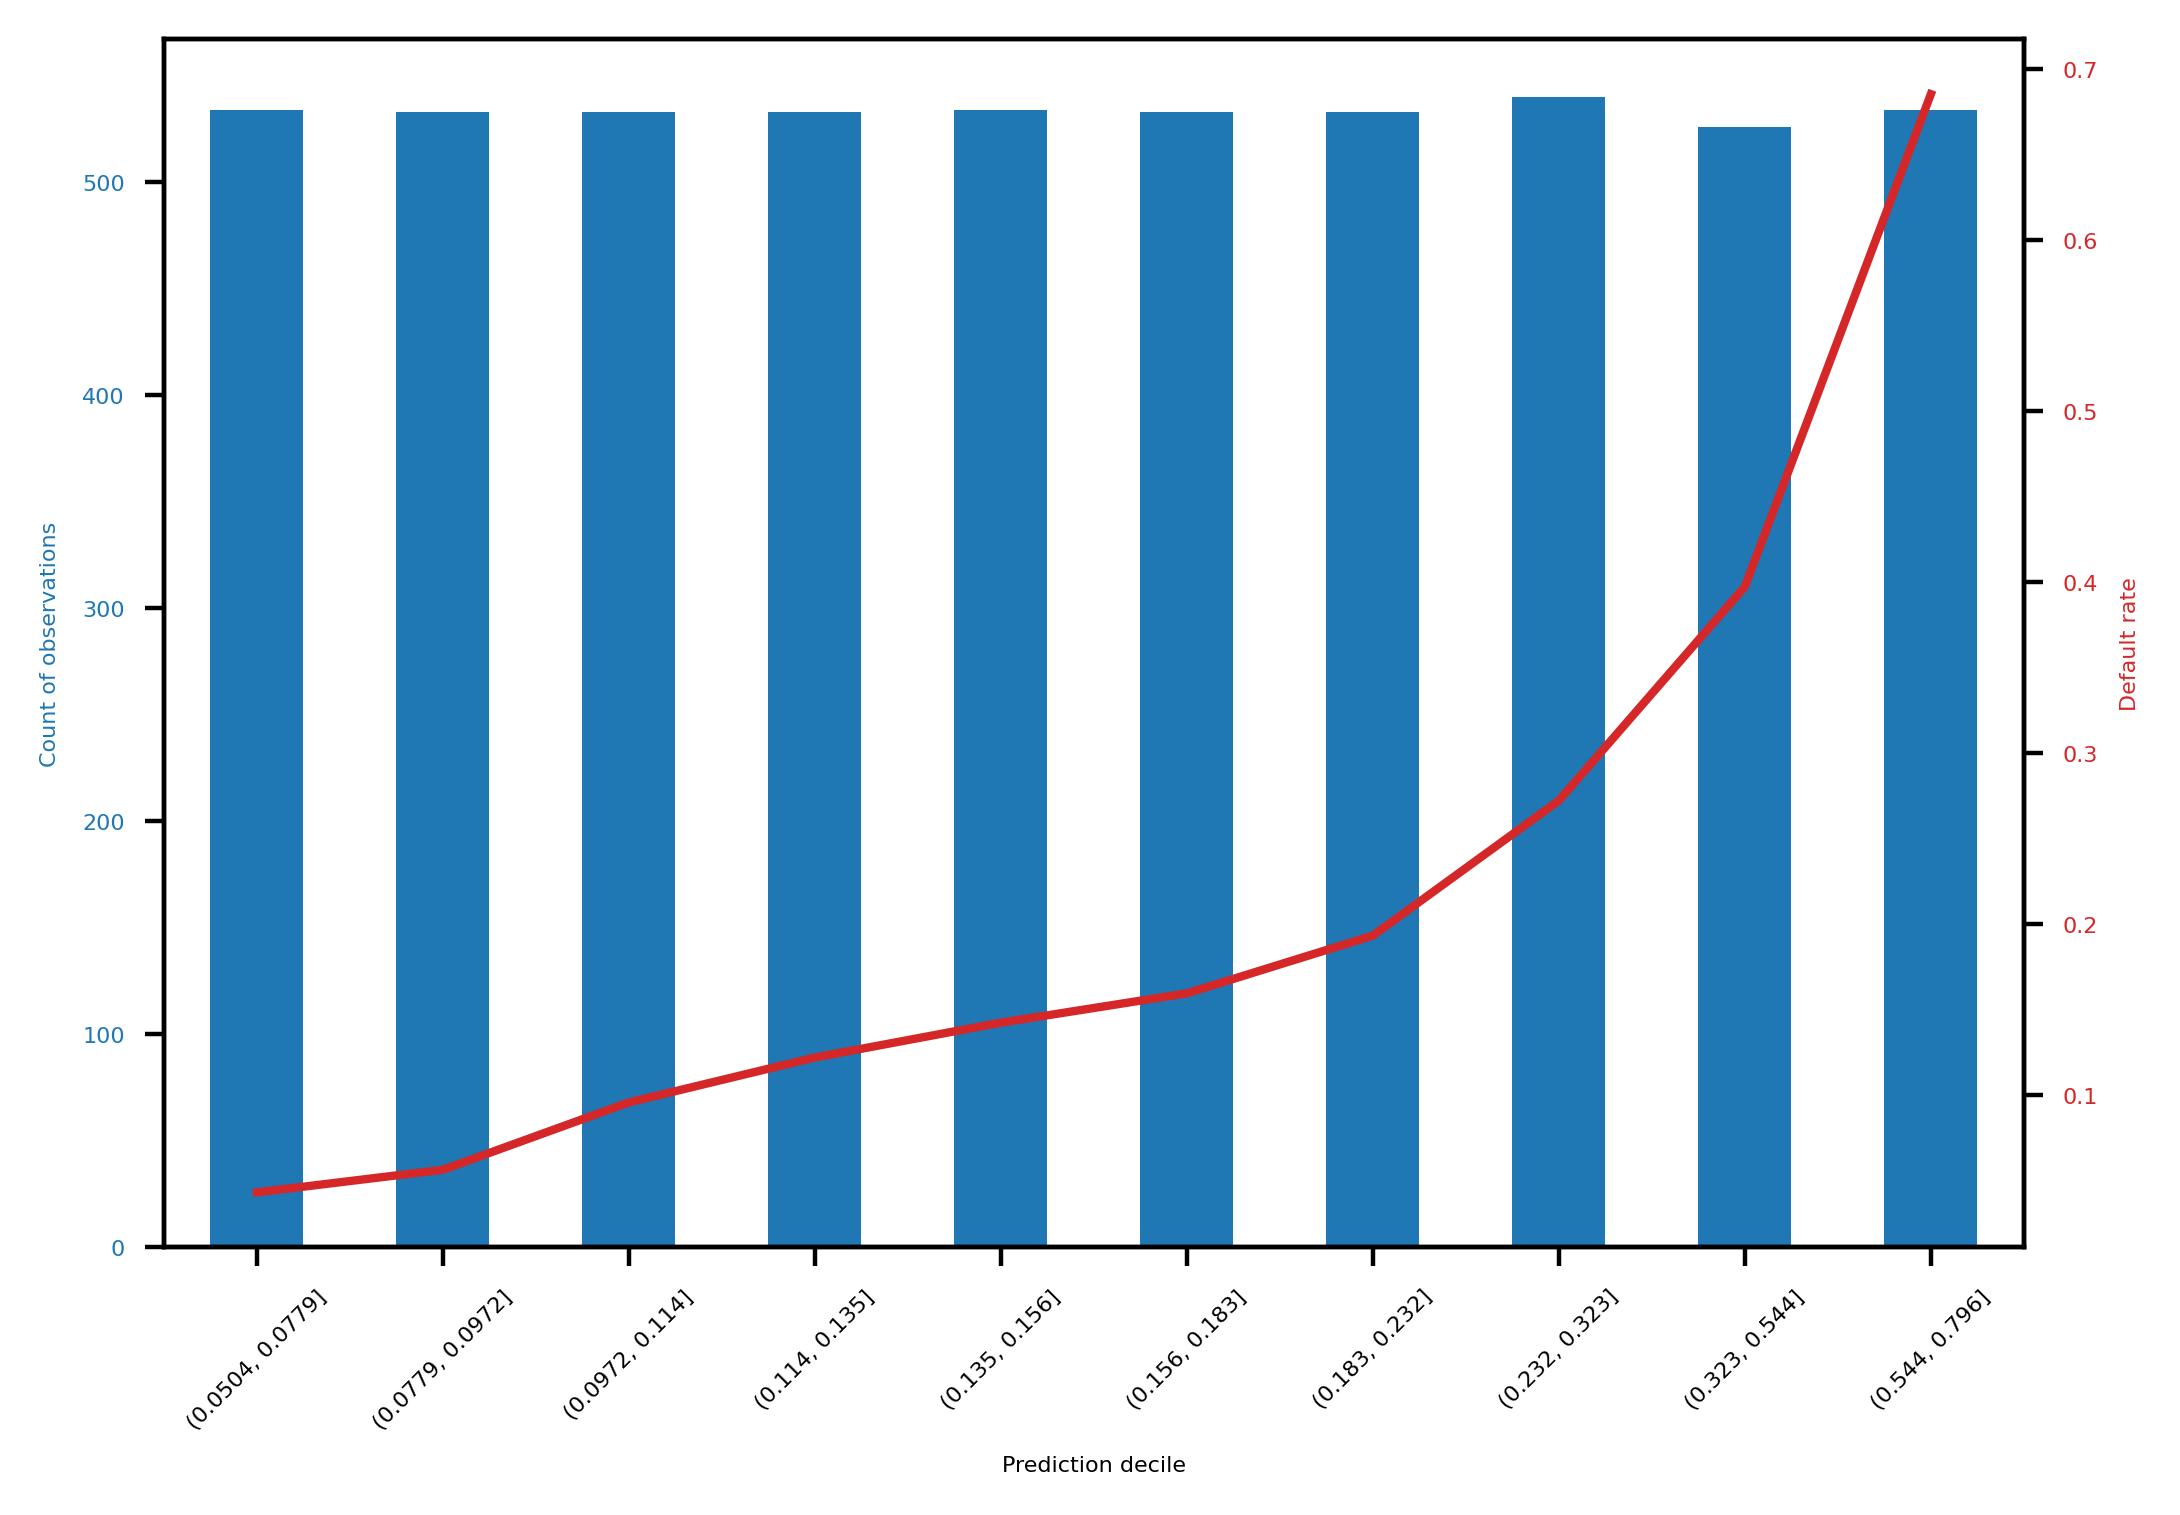

In [229]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)

It's clear that default risk increases with each decile,
where the riskiest 10% of borrowers have a default rate close to 70%, but the least
risky are below 10%. When a model is able to effectively distinguish groups of
borrowers with consistently increasing default risk, the model is said to slope the
population being examined. Notice also that the default rate is relatively flat across
the lowest 5 to 7 deciles, likely because these observations are mostly clustered in the
range [0, 0.2] of predicted risk,

In [230]:
equal_intervals, equal_interval_bin_edges = \
    pd.cut(x=test_set_pred_proba,
           bins=5,
           retbins=True)

In [231]:
equal_interval_bin_edges

array([0.05070434, 0.20031276, 0.34917686, 0.49804096, 0.64690506,
       0.79576916])

In [232]:
equal_interval_bin_edges[1:] - equal_interval_bin_edges[:-1]

array([0.14960842, 0.1488641 , 0.1488641 , 0.1488641 , 0.1488641 ])

In [233]:
print(test_set_pred_proba.min())
print(test_set_pred_proba.max())

0.05144866
0.79576916


In [234]:
test_set_bins_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                                 'Prediction bin':equal_intervals,
                                 'Outcome':y_test_all})
test_set_bins_df.head()

,Predicted probability,Prediction bin,Outcome
0,0.643179,"(0.498, 0.647]",0
1,0.477579,"(0.349, 0.498]",0
2,0.083808,"(0.0507, 0.2]",0
3,0.779496,"(0.647, 0.796]",1
4,0.296666,"(0.2, 0.349]",0


In [235]:
test_set_equal_gr = test_set_bins_df.groupby('Prediction bin')
gr_eq_df = test_set_equal_gr.agg({'Outcome':['count', 'mean']})

In [236]:
gr_eq_df

Outcome          
                 count      mean
Prediction bin                  
(0.0507, 0.2]     3429  0.108486
(0.2, 0.349]       955  0.260733
(0.349, 0.498]     371  0.388140
(0.498, 0.647]     158  0.550633
(0.647, 0.796]     420  0.721429

In [237]:
p = gr_eq_df[('Outcome', 'mean')].values
n = gr_eq_df[('Outcome', 'count')].values
std_err = np.sqrt(p * (1-p) / n)
std_err

array([0.0053109 , 0.01420682, 0.02530075, 0.03957338, 0.02187461])

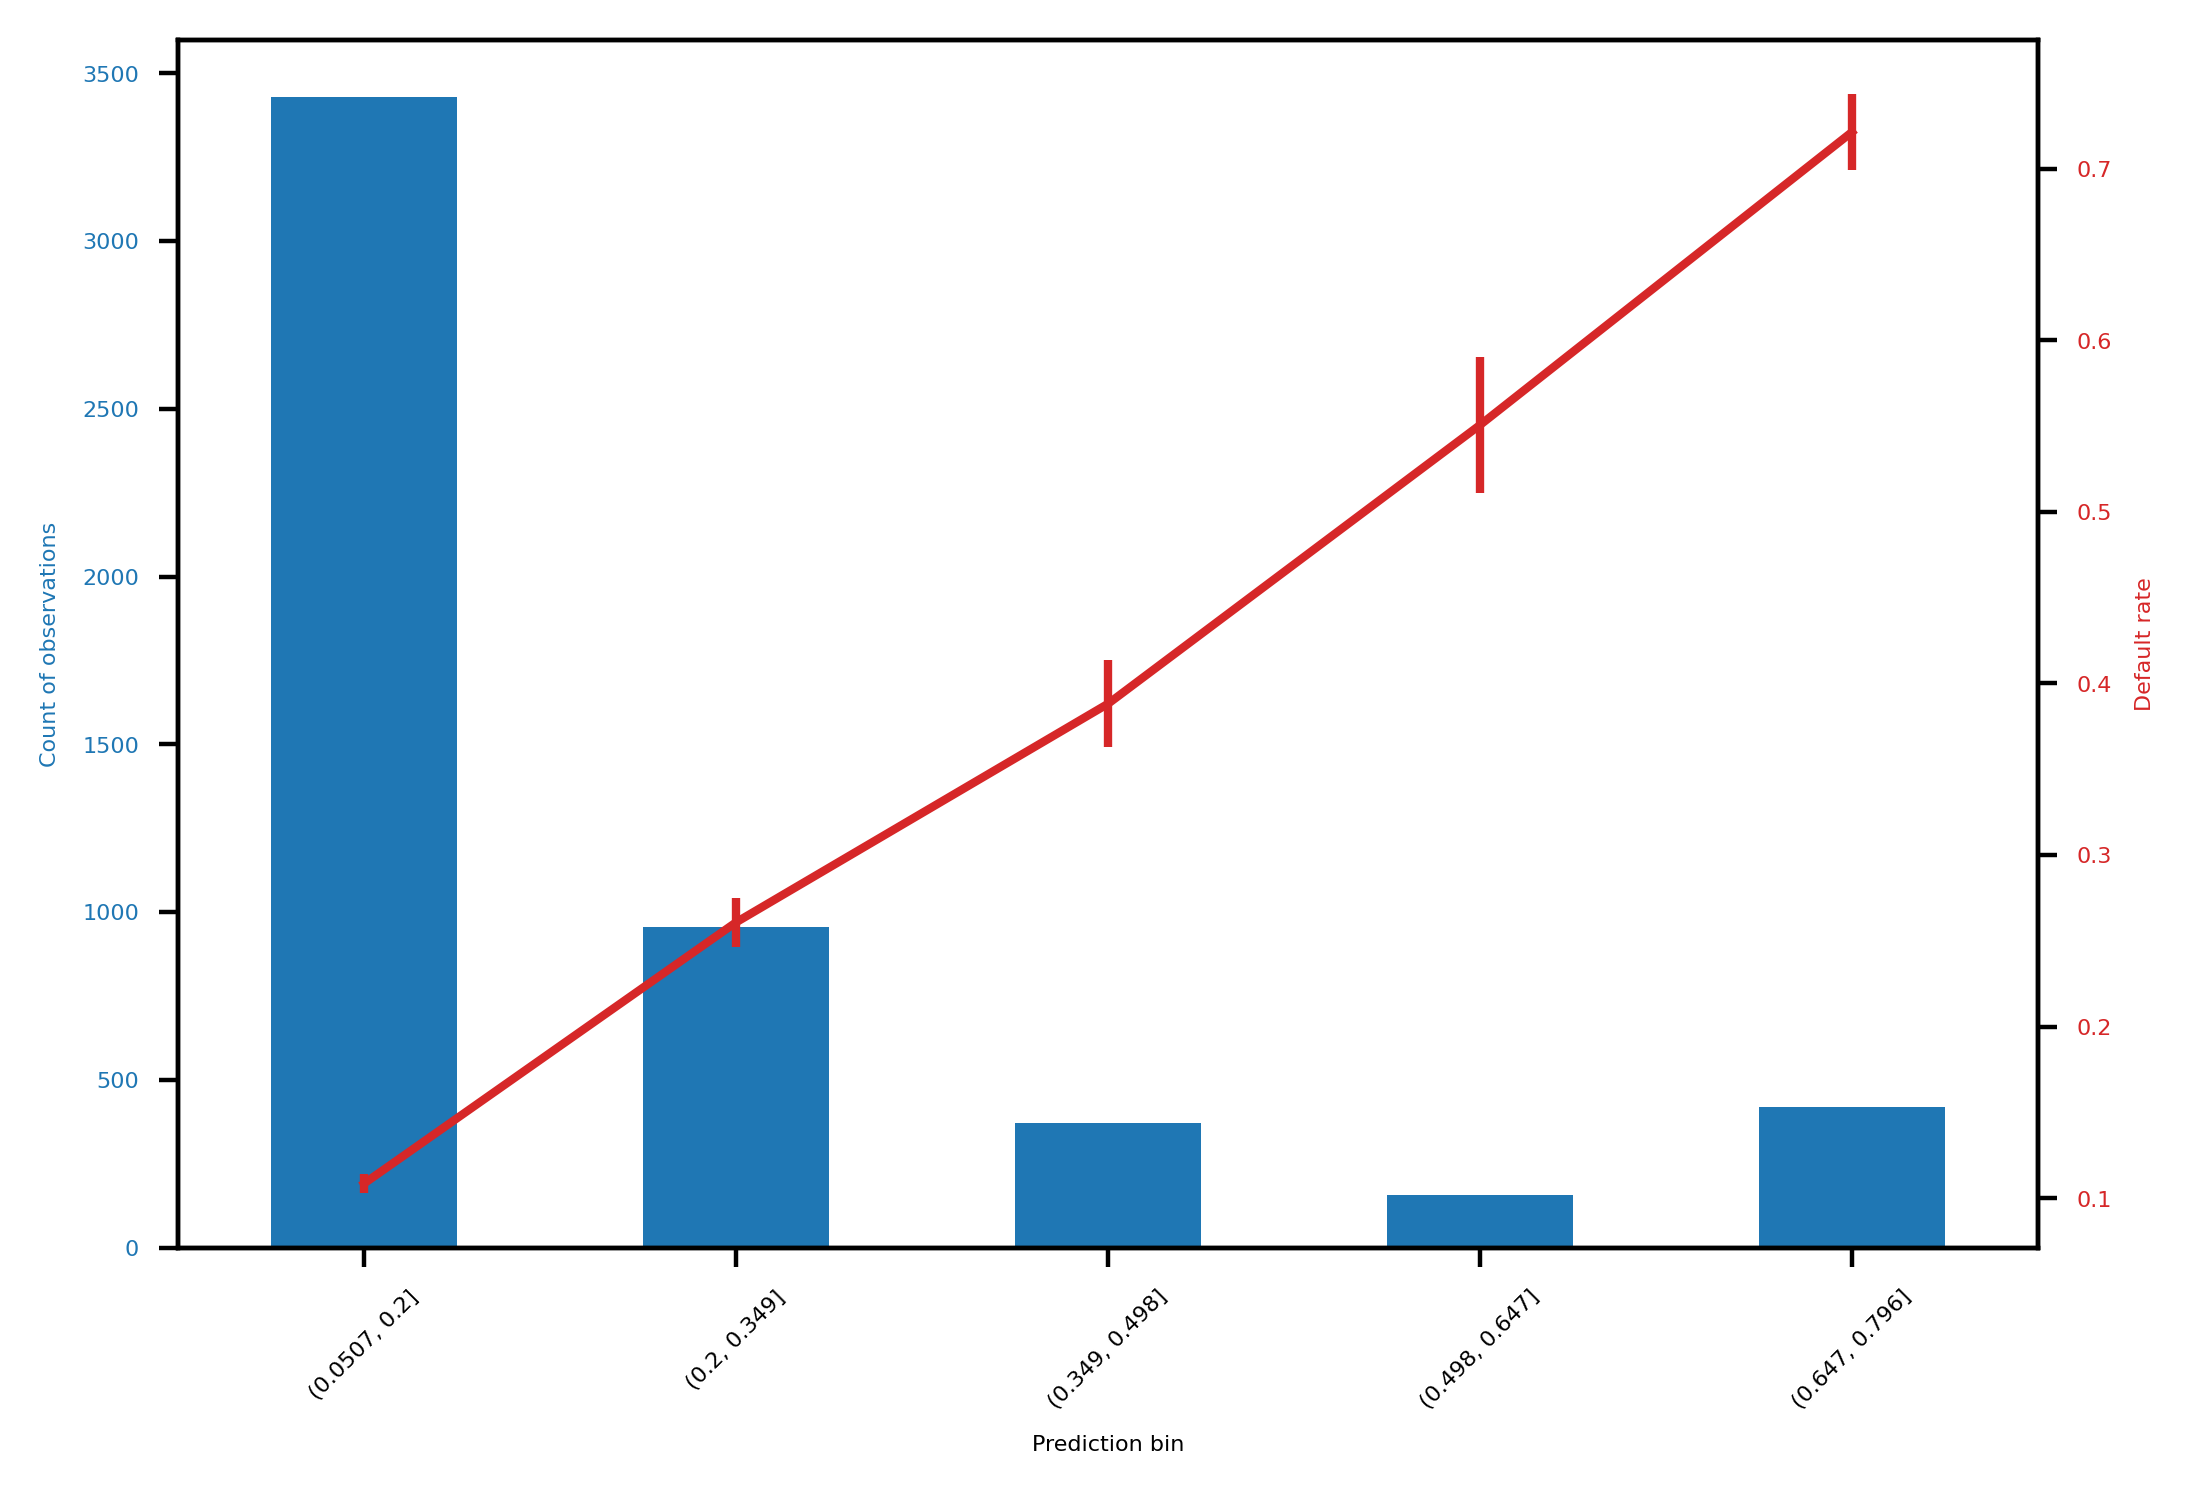

In [238]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_eq_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_eq_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2,
                                   yerr=std_err)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)

We can see that the number of samples is pretty different among the
different bins, in contrast to the quantile approach. While there are relatively few
samples in the higher score bins, leading to a larger standard error, the error bars on
the plot of default rate are still small compared to the overall trend of an increasing
default rate from lower to higher score bins, so we can be confident in this trend.

In [239]:
cal_df = test_set_gr.agg({'Outcome':['count', 'mean'],
                          'Predicted probability':'mean'})
cal_df

Outcome           Predicted probability
                    count      mean                  mean
Prediction decile                                        
(0.0504, 0.0779]      534  0.043071              0.068921
(0.0779, 0.0972]      533  0.056285              0.087859
(0.0972, 0.114]       533  0.095685              0.105370
(0.114, 0.135]        533  0.121951              0.123882
(0.135, 0.156]        534  0.142322              0.144969
(0.156, 0.183]        533  0.159475              0.169014
(0.183, 0.232]        533  0.193246              0.205380
(0.232, 0.323]        540  0.272222              0.275258
(0.323, 0.544]        526  0.397338              0.404792
(0.544, 0.796]        534  0.685393              0.689795

In [240]:
y_test_all.shape

(5333,)

In [241]:
F = cal_df[('Outcome', 'count')].values/y_test_all.shape[0]
F

array([0.10013126, 0.09994375, 0.09994375, 0.09994375, 0.10013126,
       0.09994375, 0.09994375, 0.10125633, 0.09863116, 0.10013126])

In [242]:
ECE = np.sum(
    F
    * np.abs(
             cal_df[('Outcome', 'mean')]
             - cal_df[('Predicted probability', 'mean')]))
ECE

0.010819250239611522

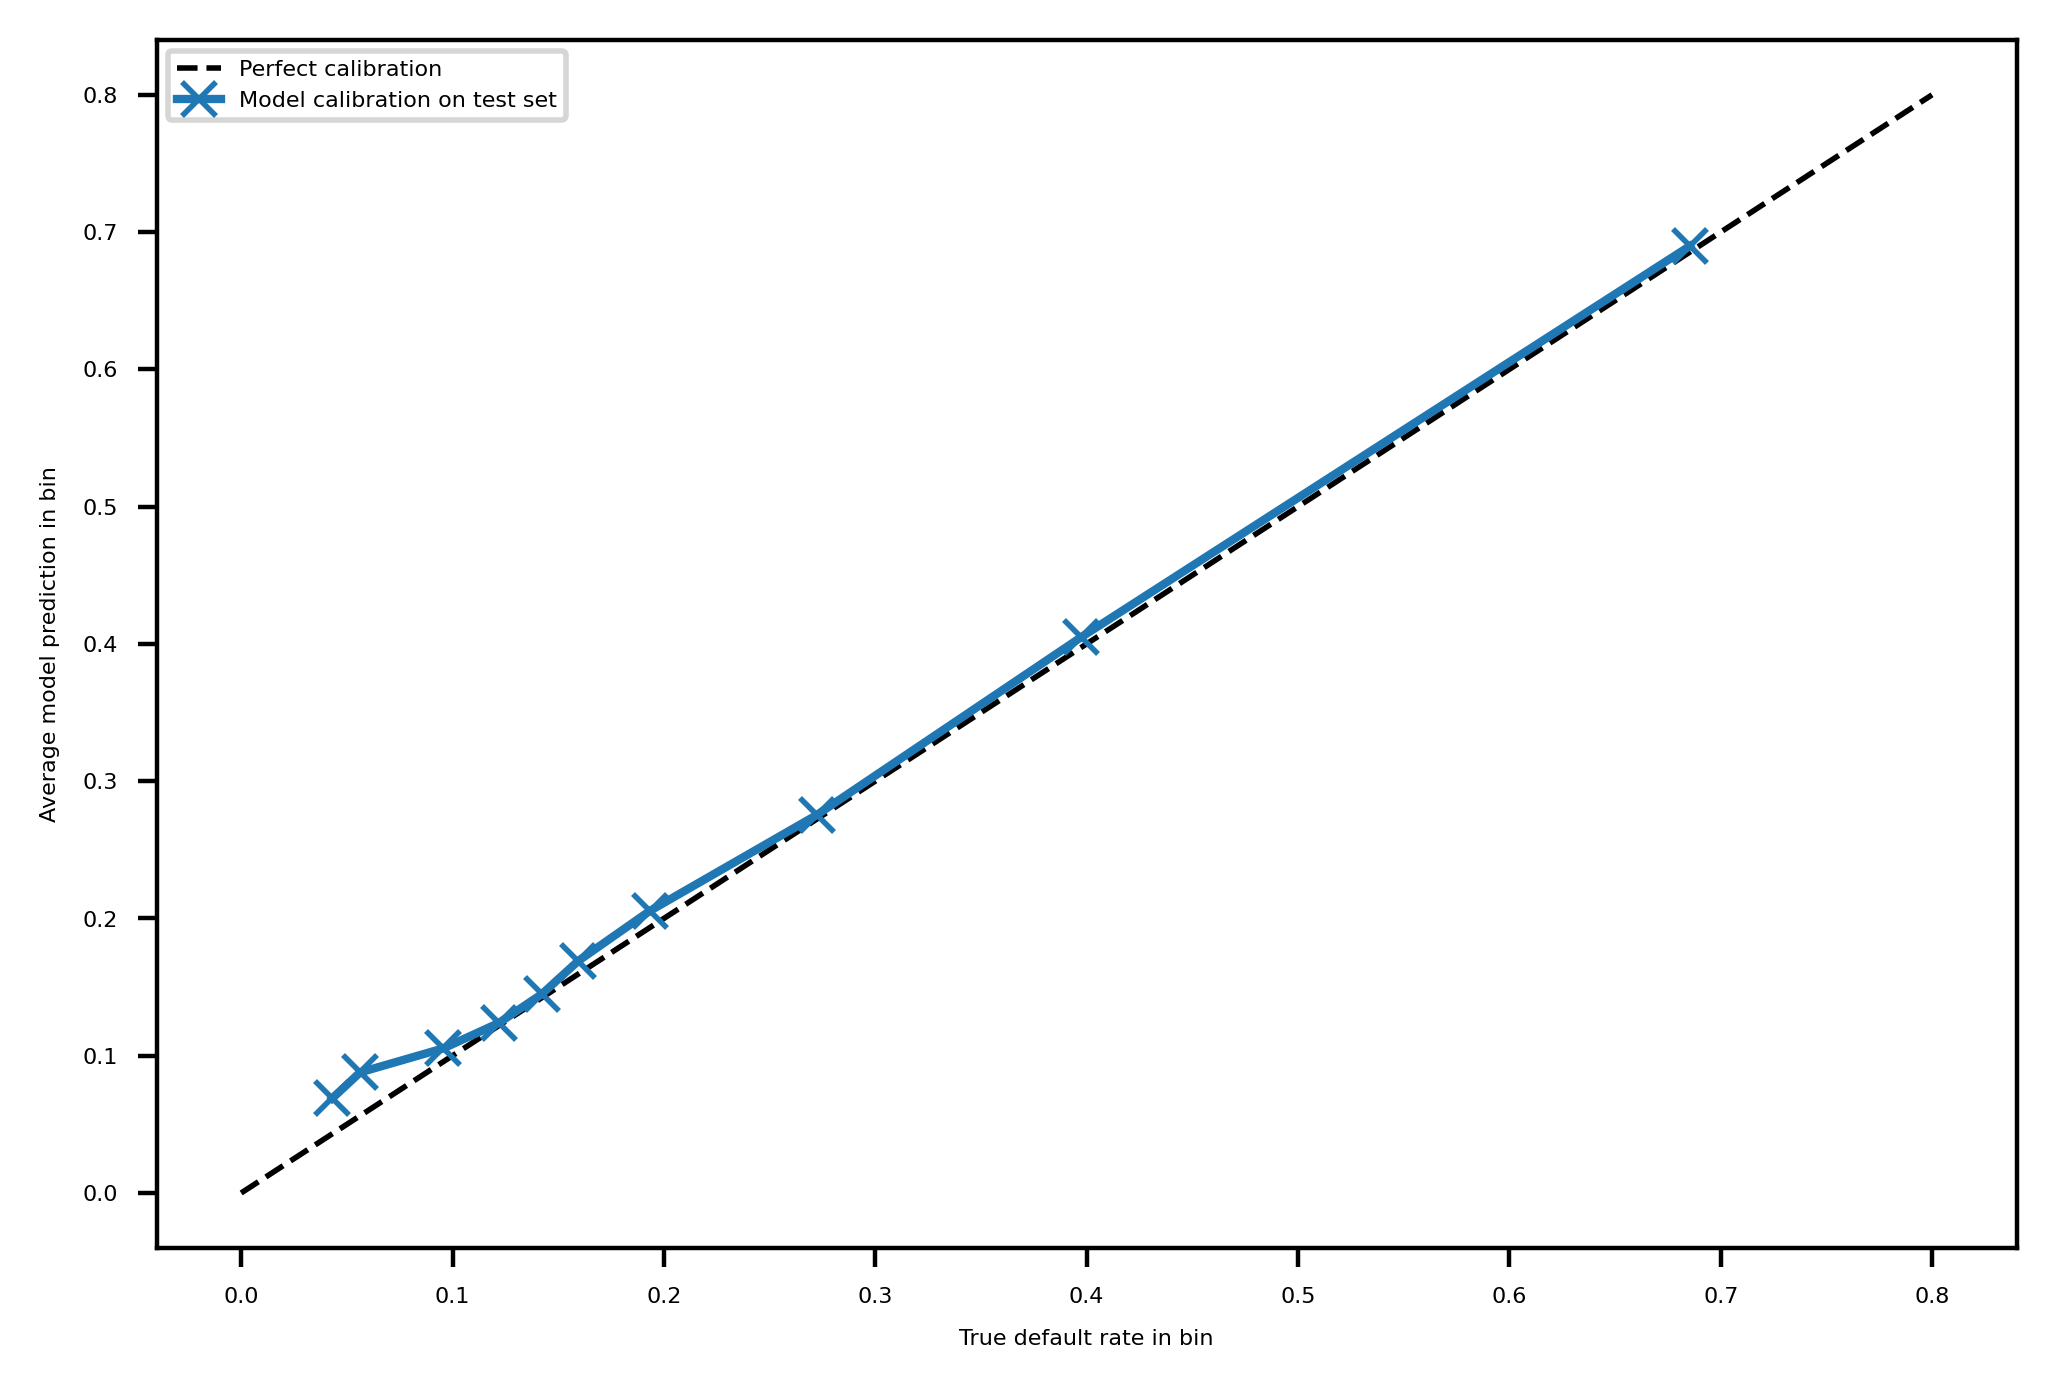

In [243]:
ax = plt.axes()
ax.plot([0, 0.8], [0, 0.8], 'k--', linewidth=1,
        label='Perfect calibration')
ax.plot(cal_df[('Outcome', 'mean')],
        cal_df[('Predicted probability', 'mean')],
        marker='x',
        label='Model calibration on test set')
ax.set_xlabel('True default rate in bin')
ax.set_ylabel('Average model prediction in bin')
ax.legend()

Model-predicted probabilities are very close to the true default
rates, so the model appears to be well calibrated.

## **Characterizing Costs and Savings**

We will characterize the expected costs of the counseling program, in terms
of costs of offering individual counseling sessions, as well as the expected savings,
in terms of prevented defaults, at a range of thresholds. There will be different
costs and savings at each threshold, because each threshold is expected to result
in a different number of positive predictions, as well as a different number of true
positives within these

In [244]:
thresholds = np.linspace(0, 1, 101)
features_response[5]

'BILL_AMT1'

In [245]:
cost_per_counseling = 7500

We also know from the client that the counseling program isn't 100% effective.
We should take this into account in our analysis

In [246]:
effectiveness = 0.70

we will calculate costs and savings for each of the thresholds

In [247]:
n_pos_pred = np.empty_like(thresholds)
total_cost = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
total_savings = np.empty_like(thresholds)
counter = 0
for threshold in thresholds:
    pos_pred = test_set_pred_proba > threshold
    n_pos_pred[counter] = sum(pos_pred)
    total_cost[counter] \
        = n_pos_pred[counter] * cost_per_counseling
    
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    total_savings[counter] = np.sum(
        true_pos.astype(int)
        * X_test_all[:,5]
        * effectiveness
        )
    counter += 1

In [248]:
net_savings = total_savings - total_cost

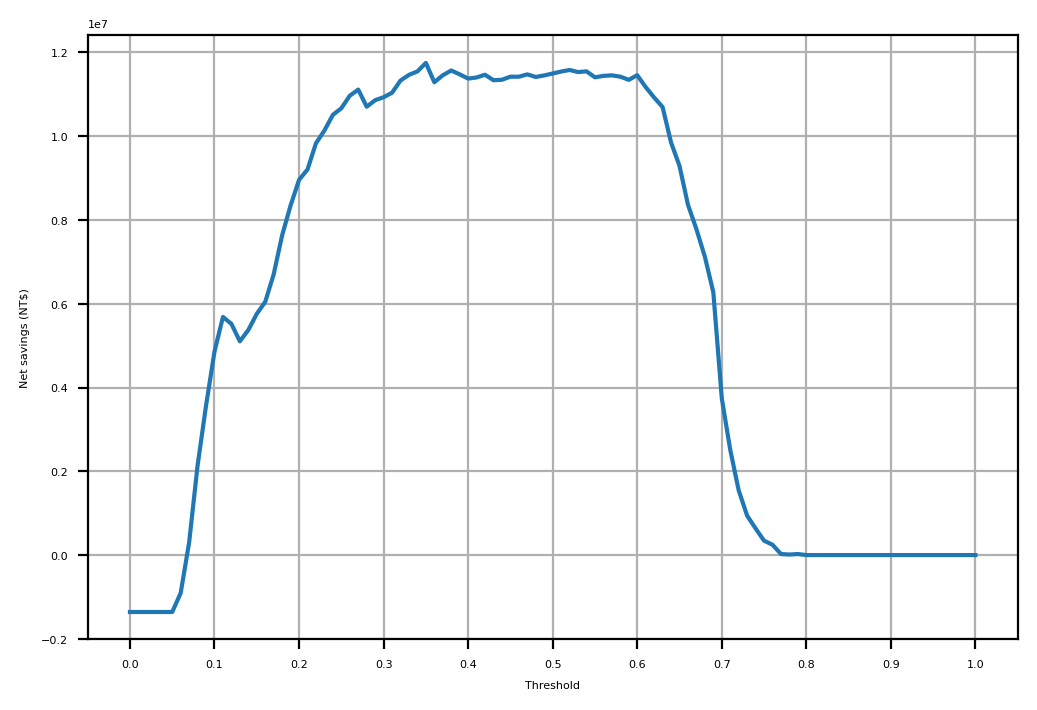

In [249]:
mpl.rcParams['figure.dpi'] = 200
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

The plot indicates that the choice of threshold is important. While it will be
possible to create net savings at many different values of the threshold, it
looks like the highest net savings will be generated by setting the threshold
somewhere in the range of about 0.25 to 0.5.

In [250]:
max_savings_ix = np.argmax(net_savings)

In [251]:
max_savings_ix = np.argmax(net_savings)
thresholds[max_savings_ix]

0.35000000000000003

In [252]:
net_savings[max_savings_ix]

11749622.799999997

We see that the greatest net savings occurs at a threshold of 0.35. The amount of
net savings realized at this threshold is over NT$11 million, for this testing dataset of
accounts. These savings would need to be scaled by the number of accounts served
by the client, to estimate the total possible savings, assuming the data we are working
with is representative of all these accounts.

In [253]:
cost_of_defaults = np.sum(y_test_all * X_test_all[:,5])
cost_of_defaults

55198017

In [254]:
net_savings[max_savings_ix]/cost_of_defaults

0.21286313238390425

Results indicate that we can decrease the cost of defaults by 21% using a
counseling program, guided by predictive modeling.

In [255]:
net_savings[max_savings_ix]/len(y_test_all)

2203.1919744984057

Results like these help the client scale the potential amount of savings they could
create with the counseling program, to as many accounts as they serve.

Text(0, 0.5, 'Net savings per account (NT$)')

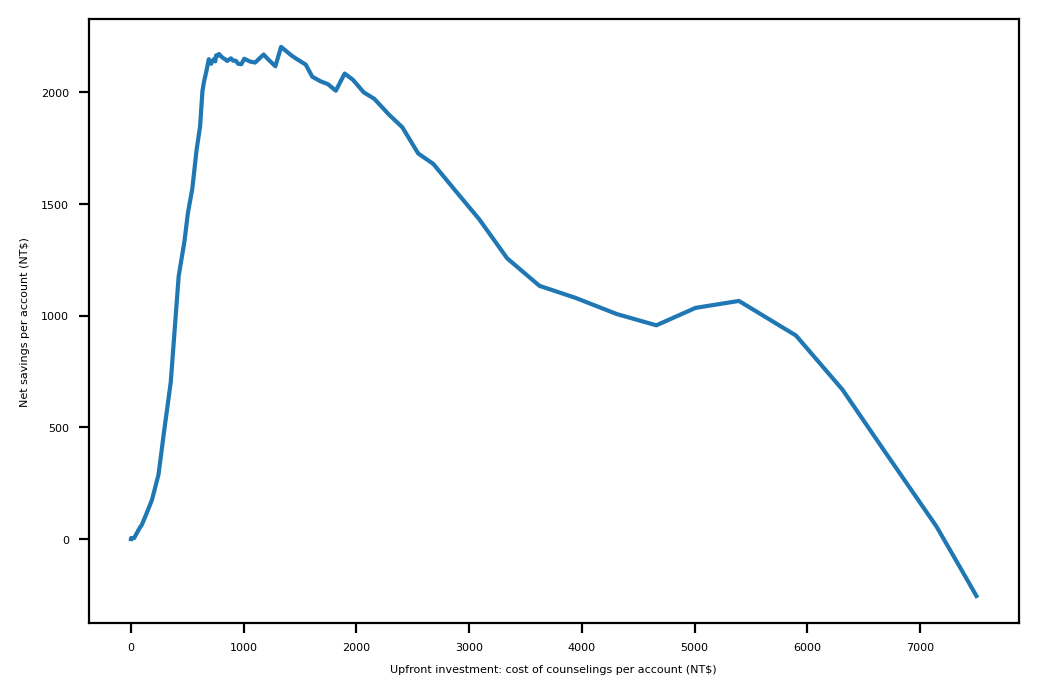

In [256]:
plt.plot(total_cost/len(y_test_all),
         net_savings/len(y_test_all))
plt.xlabel('Upfront investment: cost of counselings per account (NT$)')
plt.ylabel('Net savings per account (NT$)')

This indicates how much money the client needs to budget to the counseling
program in a given month, to achieve a given amount of savings. It looks like the
greatest benefit can be created by budgeting up to about NT$1300 per account.

 However, net savings are relatively flat for upfront
investments between NT$1000 and 2000, being lower outside that range. The
client may not actually be able to budget this much for the program. However,
this graphic gives them evidence to argue for a larger budget if they need to.

Text(0.5, 0, 'Threshold')

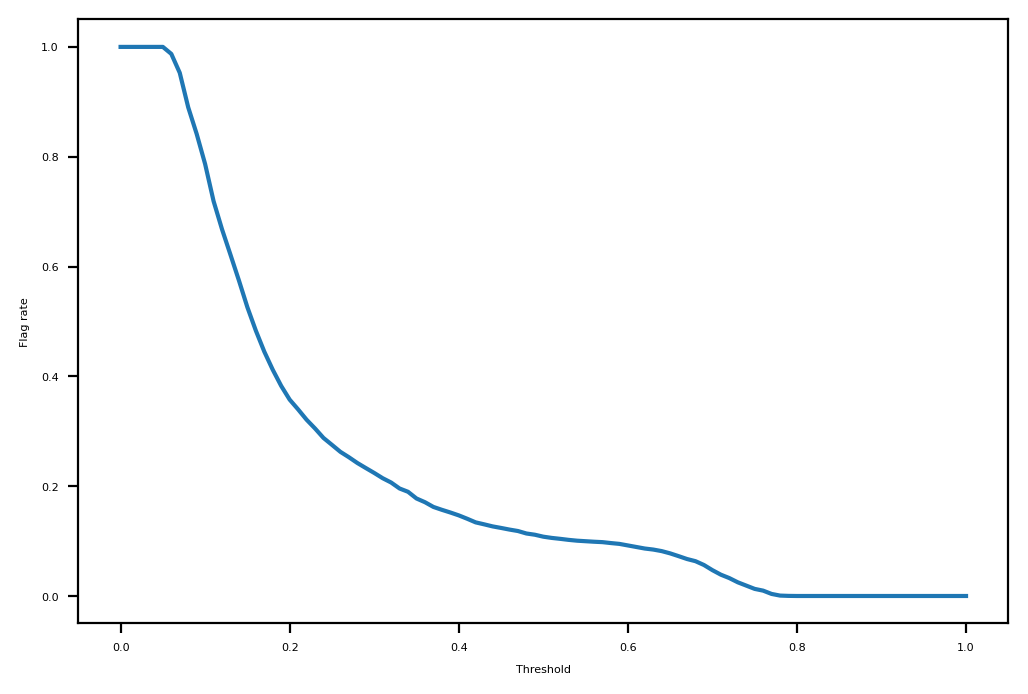

In [257]:
plt.plot(thresholds, n_pos_pred/len(y_test_all))
plt.ylabel('Flag rate')
plt.xlabel('Threshold')

This plot shows the fraction of people who will be predicted to default and
therefore will be recommended outreach at each threshold. It appears that at
the optimal threshold of 0.35, only about 20% of accounts will be flagged for
counseling. This shows how using a model to prioritize accounts for counseling
can help focus on the right accounts and reduce wasted resources. 

invalid value encountered in true_divide


Text(0, 0.5, 'Precision')

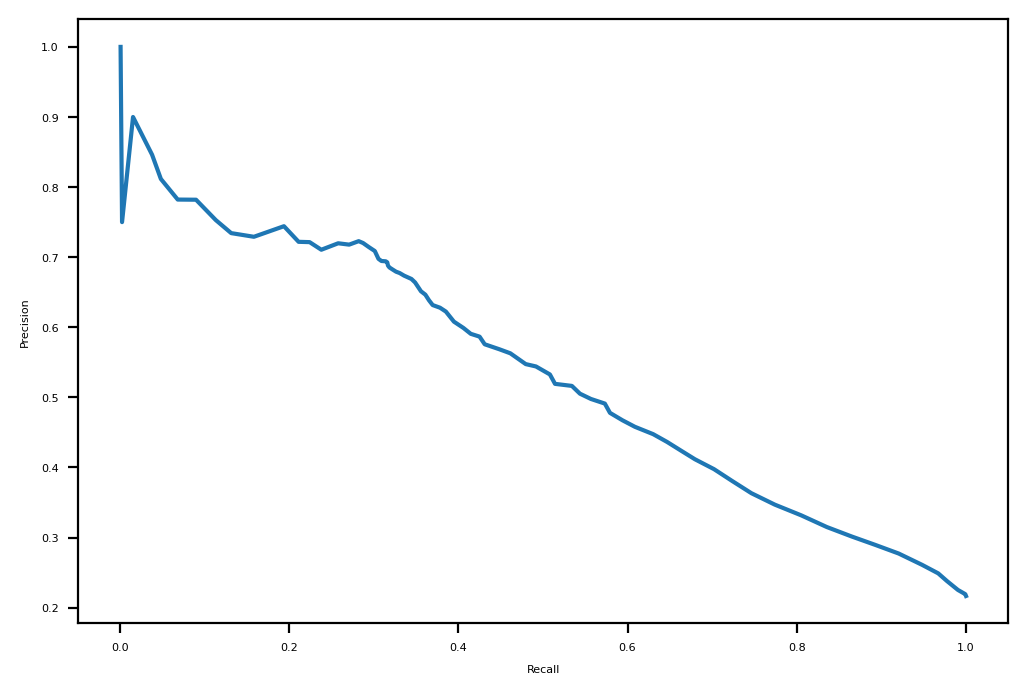

In [258]:
plt.plot(n_true_pos/sum(y_test_all),
         np.divide(n_true_pos, n_pos_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')

shows that in order to start getting a true positive rate (that is, recall)
much above 0, we need to accept a precision of about 0.8 or lower.

invalid value encountered in true_divide


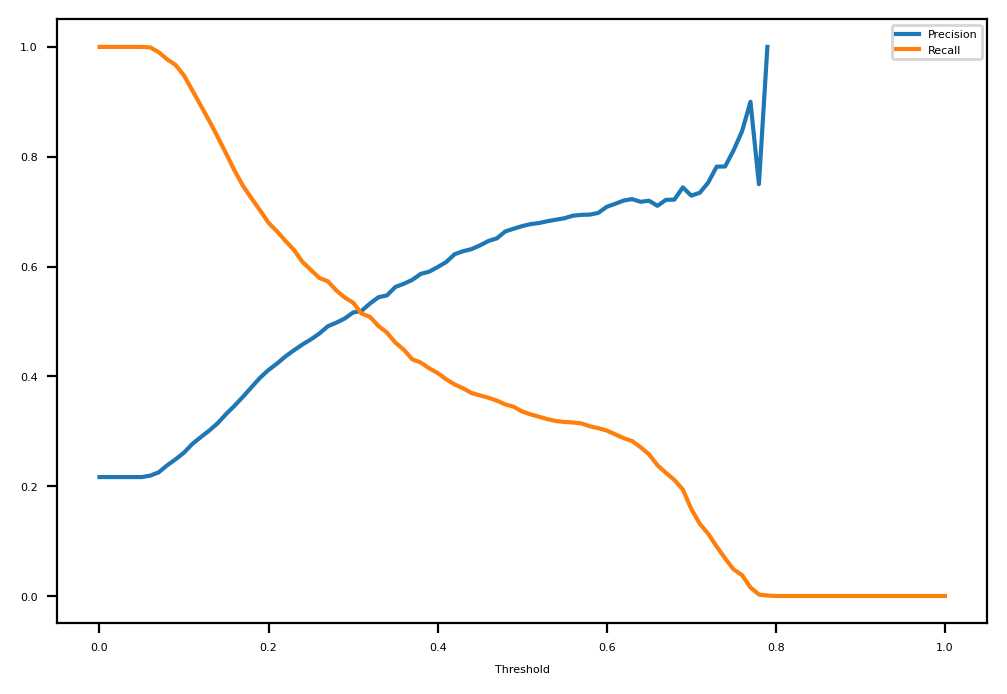

In [259]:
plt.plot(thresholds, np.divide(n_true_pos, n_pos_pred),
         label='Precision')
plt.plot(thresholds, n_true_pos/sum(y_test_all),
         label='Recall')
plt.xlabel('Threshold')
plt.legend()

This plot sheds some light on why the optimal threshold turned out to be 0.35.
While the optimal threshold also depends on the financial analysis of costs and
savings, we can see here that the steepest part of the initial increase in precision,
which represents the correctness of positive predictions and is therefore a
measure of how cost-effective the model-guided counseling can be, happens up
to a threshold of about 0.35.

## **Final Thoughts**

A key contribution is the predictive capability embodied in the trained model.
Assuming the client can work with the trained model object we created with XGBoost,
this model could be saved to disk as we've done and sent to the client. Then, the
client would be able to use it within their workflow.